In [ ]:
!pip install control
!pip install scikit-fuzzy
!pip install numpy
!pip install matplotlib
!pip install tensorflow

!gdown 1BxA6O1L1sB6wHltotLMBHLetVf1q7BPh
!gdown 14X0al7arY8Qhj6mrQcjYItk7hMyv00A4
!gdown 1L9zNT7xCnCldp_OGN093JbOUtxnfizq9

Downloading...
From: https://drive.google.com/uc?id=1BxA6O1L1sB6wHltotLMBHLetVf1q7BPh
To: /content/ballbeam.dat
100% 35.0k/35.0k [00:00<00:00, 57.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=14X0al7arY8Qhj6mrQcjYItk7hMyv00A4
To: /content/steamgen.dat
100% 2.26M/2.26M [00:00<00:00, 35.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L9zNT7xCnCldp_OGN093JbOUtxnfizq9
To: /content/AirQualityUCI.xlsx
100% 1.30M/1.30M [00:00<00:00, 65.2MB/s]


In [ ]:
import numpy as np
import control
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


پرسش 1

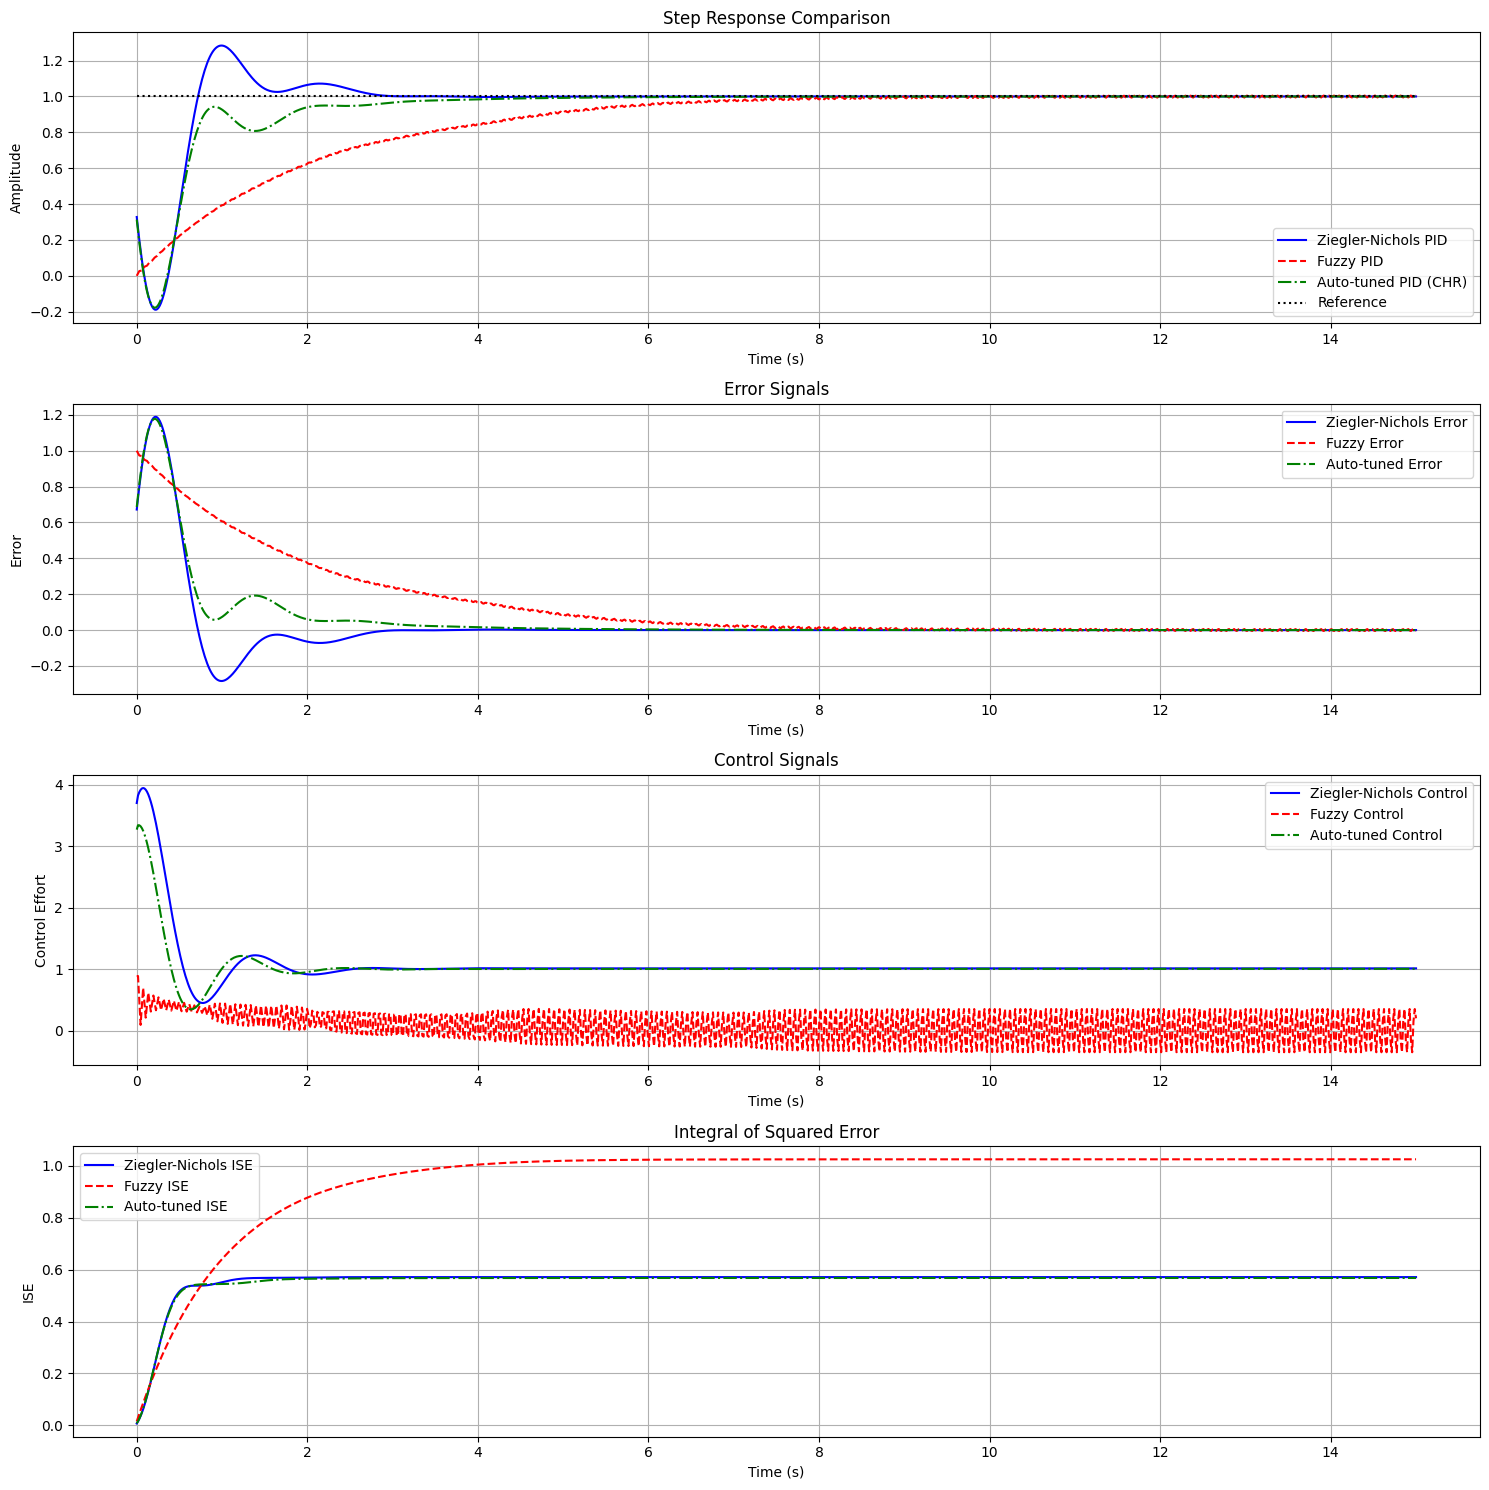


Controller Parameters:

Ziegler-Nichols PID:
Kp = 2.309
Ki = 2.732
Kd = 0.488

Auto-tuned PID (CHR method):
Kp = 1.827
Ki = 1.202
Kd = 0.457

Performance Metrics:

Ziegler-Nichols PID Performance:
Overshoot (%): 28.383
Settling Time (s): 0.721
Rise Time (s): 0.180
Peak: 1.284
Steady State: 1.000

Fuzzy PID Performance:
Overshoot (%): 0.000
Settling Time (s): 7.252
Rise Time (s): 4.580
Peak: 1.005
Steady State: 1.005

Auto-tuned PID Performance:
Overshoot (%): 0.000
Settling Time (s): 3.709
Rise Time (s): 0.345
Peak: 1.000
Steady State: 1.000

Additional Performance Metrics:

Ziegler-Nichols:
IAE: 0.767
ISE: 0.571
ITAE: 0.447

Fuzzy PID:
IAE: 2.034
ISE: 1.025
ITAE: 4.035

Auto-tuned PID:
IAE: 0.837
ISE: 0.568
ITAE: 0.708


In [ ]:
import numpy as np
import control
import matplotlib.pyplot as plt
from scipy import signal
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# تعریف سیستم
num = [1]
den = [1, 1]
sys = control.TransferFunction(num, den)

# اضافه کردن تأخیر
delay = 0.5
n_pade = 2
num_delay, den_delay = control.pade(delay, n_pade)
sys_delay = control.TransferFunction(num_delay, den_delay)
sys_with_delay = sys * sys_delay

# زمان شبیه‌سازی
t = np.linspace(0, 15, 1000)

# تابع محاسبه پارامترهای عملکرد
def calculate_performance(y, t):
    steady_state = y[-1]
    settling_time = 0
    peak = max(y)
    rise_time = 0
    overshoot = (peak - steady_state) / steady_state * 100 if steady_state != 0 else 0

    # محاسبه زمان نشست (2%)
    steady_state_threshold = 0.02
    for i in range(len(y)):
        if abs(y[i] - steady_state) <= steady_state_threshold * steady_state:
            settling_time = t[i]
            break

    # محاسبه زمان صعود (10% تا 90%)
    y_normalized = (y - y[0]) / (steady_state - y[0]) if steady_state != y[0] else y
    for i in range(len(y)):
        if y_normalized[i] >= 0.1:
            t1 = t[i]
            break
    for i in range(len(y)):
        if y_normalized[i] >= 0.9:
            t2 = t[i]
            rise_time = t2 - t1
            break

    return {
        'Overshoot (%)': overshoot,
        'Settling Time (s)': settling_time,
        'Rise Time (s)': rise_time,
        'Peak': peak,
        'Steady State': steady_state
    }

# تنظیم PID با روش زیگلر-نیکولز
def ziegler_nichols_tune(sys):
    gm, pm, wg, wp = control.margin(sys)
    Ku = gm
    Tu = 2*np.pi/wg

    Kp = 0.6 * Ku
    Ti = Tu/2
    Td = Tu/8

    Ki = Kp/Ti
    Kd = Kp*Td

    return Kp, Ki, Kd

# روش تنظیم خودکار جایگزین (CHR method - Chien, Hrones, and Reswick)
def auto_tune(sys):
    # دریافت پاسخ پله سیستم
    t_temp, y_temp = control.step_response(sys)

    # محاسبه پارامترهای مدل مرتبه اول با تأخیر
    steady_state = y_temp[-1]

    # یافتن زمان تأخیر و ثابت زمانی
    idx_63 = np.where(y_temp >= 0.632 * steady_state)[0][0]
    tau = t_temp[idx_63]

    # محاسبه پارامترها با روش CHR
    Kp = 0.6 * tau / (delay * steady_state)
    Ti = tau
    Td = 0.5 * delay

    Ki = Kp / Ti
    Kd = Kp * Td

    return Kp, Ki, Kd

# تنظیم PID زیگلر-نیکولز
Kp_zn, Ki_zn, Kd_zn = ziegler_nichols_tune(sys_with_delay)
pid_zn = control.TransferFunction([Kd_zn, Kp_zn, Ki_zn], [1, 0])
sys_cl_zn = control.feedback(pid_zn * sys_with_delay)

# تنظیم PID خودکار
Kp_auto, Ki_auto, Kd_auto = auto_tune(sys_with_delay)
pid_auto = control.TransferFunction([Kd_auto, Kp_auto, Ki_auto], [1, 0])
sys_cl_auto = control.feedback(pid_auto * sys_with_delay)

# شبیه‌سازی پاسخ‌ها
t_zn, y_zn = control.step_response(sys_cl_zn, t)
t_auto, y_auto = control.step_response(sys_cl_auto, t)

# افازی برای کنترل‌کننده
def create_fuzzy_pid():
    error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'error')
    d_error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'delta_error')
    pid_output = ctrl.Consequent(np.linspace(-1, 1, 7), 'output')

    names = ['nb', 'nm', 'ns', 'z', 'ps', 'pm', 'pb']
    error.automf(names=names)
    d_error.automf(names=names)
    pid_output.automf(names=names)

    rules = []
    for i in range(7):
        for j in range(7):
            rules.append(ctrl.Rule(error[names[i]] & d_error[names[j]],
                                 pid_output[names[min(6, max(0, i + j - 3))]]))

    fuzzy_pid = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(fuzzy_pid)

# شبیه‌سازی فازی PID
fuzzy_controller = create_fuzzy_pid()
t_fuzzy = t
y_fuzzy = np.zeros_like(t)
error_prev = 0
for i in range(len(t)-1):
    if i == 0:
        error = 1
    else:
        error = 1 - y_fuzzy[i-1]

    d_error = (error - error_prev) / (t[1] - t[0])

    fuzzy_controller.input['error'] = np.clip(error, -1, 1)
    fuzzy_controller.input['delta_error'] = np.clip(d_error, -1, 1)
    fuzzy_controller.compute()

    dt = t[1] - t[0]
    y_fuzzy[i+1] = y_fuzzy[i] + fuzzy_controller.output['output'] * dt
    error_prev = error

# رسم نمودارها
plt.figure(figsize=(15, 15))

# پاسخ پله
plt.subplot(411)
plt.plot(t_zn, y_zn, 'b-', label='Ziegler-Nichols PID')
plt.plot(t_fuzzy, y_fuzzy, 'r--', label='Fuzzy PID')
plt.plot(t_auto, y_auto, 'g-.', label='Auto-tuned PID (CHR)')
plt.plot(t, np.ones_like(t), 'k:', label='Reference')
plt.grid(True)
plt.legend()
plt.title('Step Response Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# سیگنال خطا
plt.subplot(412)
error_zn = 1 - y_zn
error_fuzzy = 1 - y_fuzzy
error_auto = 1 - y_auto
plt.plot(t, error_zn, 'b-', label='Ziegler-Nichols Error')
plt.plot(t, error_fuzzy, 'r--', label='Fuzzy Error')
plt.plot(t, error_auto, 'g-.', label='Auto-tuned Error')
plt.grid(True)
plt.legend()
plt.title('Error Signals')
plt.xlabel('Time (s)')
plt.ylabel('Error')

# سیگنال کنترل
plt.subplot(413)
control_zn = Kp_zn * error_zn + Ki_zn * np.cumsum(error_zn) * (t[1] - t[0]) + Kd_zn * np.gradient(error_zn, t[1] - t[0])
control_fuzzy = np.gradient(y_fuzzy, t[1] - t[0])
control_auto = Kp_auto * error_auto + Ki_auto * np.cumsum(error_auto) * (t[1] - t[0]) + Kd_auto * np.gradient(error_auto, t[1] - t[0])

plt.plot(t, control_zn, 'b-', label='Ziegler-Nichols Control')
plt.plot(t, control_fuzzy, 'r--', label='Fuzzy Control')
plt.plot(t, control_auto, 'g-.', label='Auto-tuned Control')
plt.grid(True)
plt.legend()
plt.title('Control Signals')
plt.xlabel('Time (s)')
plt.ylabel('Control Effort')

# ISE
plt.subplot(414)
ise_zn = np.cumsum(error_zn**2) * (t[1] - t[0])
ise_fuzzy = np.cumsum(error_fuzzy**2) * (t[1] - t[0])
ise_auto = np.cumsum(error_auto**2) * (t[1] - t[0])
plt.plot(t, ise_zn, 'b-', label='Ziegler-Nichols ISE')
plt.plot(t, ise_fuzzy, 'r--', label='Fuzzy ISE')
plt.plot(t, ise_auto, 'g-.', label='Auto-tuned ISE')
plt.grid(True)
plt.legend()
plt.title('Integral of Squared Error')
plt.xlabel('Time (s)')
plt.ylabel('ISE')

plt.tight_layout()
plt.show()

# نمایش پارامترها و معیارهای عملکرد
print("\nController Parameters:")
print("\nZiegler-Nichols PID:")
print(f"Kp = {Kp_zn:.3f}")
print(f"Ki = {Ki_zn:.3f}")
print(f"Kd = {Kd_zn:.3f}")

print("\nAuto-tuned PID (CHR method):")
print(f"Kp = {Kp_auto:.3f}")
print(f"Ki = {Ki_auto:.3f}")
print(f"Kd = {Kd_auto:.3f}")

print("\nPerformance Metrics:")
zn_metrics = calculate_performance(y_zn, t)
fuzzy_metrics = calculate_performance(y_fuzzy, t)
auto_metrics = calculate_performance(y_auto, t)

print("\nZiegler-Nichols PID Performance:")
for key, value in zn_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nFuzzy PID Performance:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nAuto-tuned PID Performance:")
for key, value in auto_metrics.items():
    print(f"{key}: {value:.3f}")

# محاسبه و نمایش معیارهای عملکردی اضافی
def calculate_additional_metrics(error, t):
    dt = t[1] - t[0]
    iae = np.sum(np.abs(error)) * dt
    ise = np.sum(error**2) * dt
    itae = np.sum(np.abs(error) * t) * dt
    return {
        'IAE': iae,
        'ISE': ise,
        'ITAE': itae
    }

print("\nAdditional Performance Metrics:")
print("\nZiegler-Nichols:")
zn_add_metrics = calculate_additional_metrics(error_zn, t)
for key, value in zn_add_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nFuzzy PID:")
fuzzy_add_metrics = calculate_additional_metrics(error_fuzzy, t)
for key, value in fuzzy_add_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nAuto-tuned PID:")
auto_add_metrics = calculate_additional_metrics(error_auto, t)
for key, value in auto_add_metrics.items():
    print(f"{key}: {value:.3f}")

پرسش دوم


Testing from initial position: x=0, φ=179°


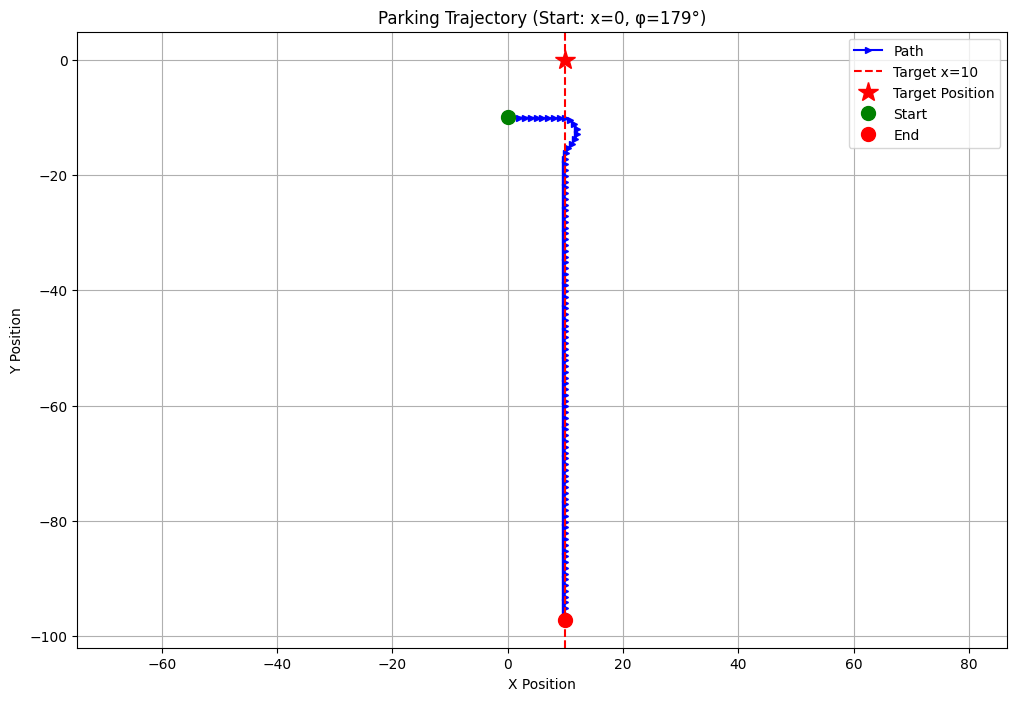

Target: x=10.00, φ=90.00
Final:  x=9.89, φ=90.00
Error:  x=0.11, φ=0.00

Testing from initial position: x=1, φ=26°


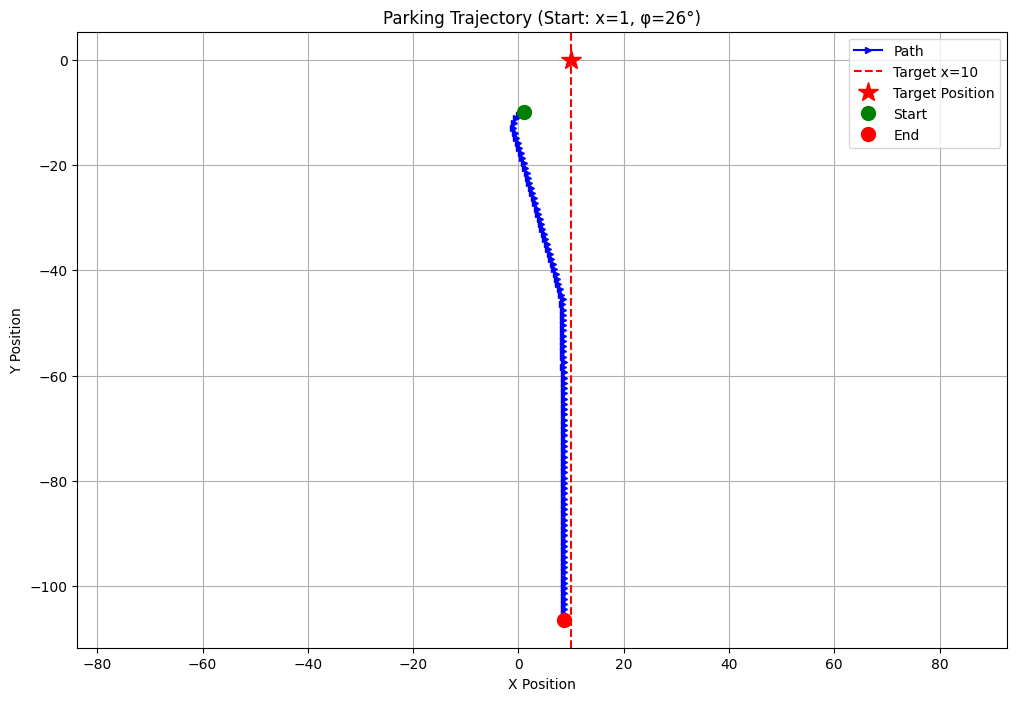

Target: x=10.00, φ=90.00
Final:  x=8.74, φ=90.11
Error:  x=1.26, φ=0.11

Testing from initial position: x=3, φ=-30°


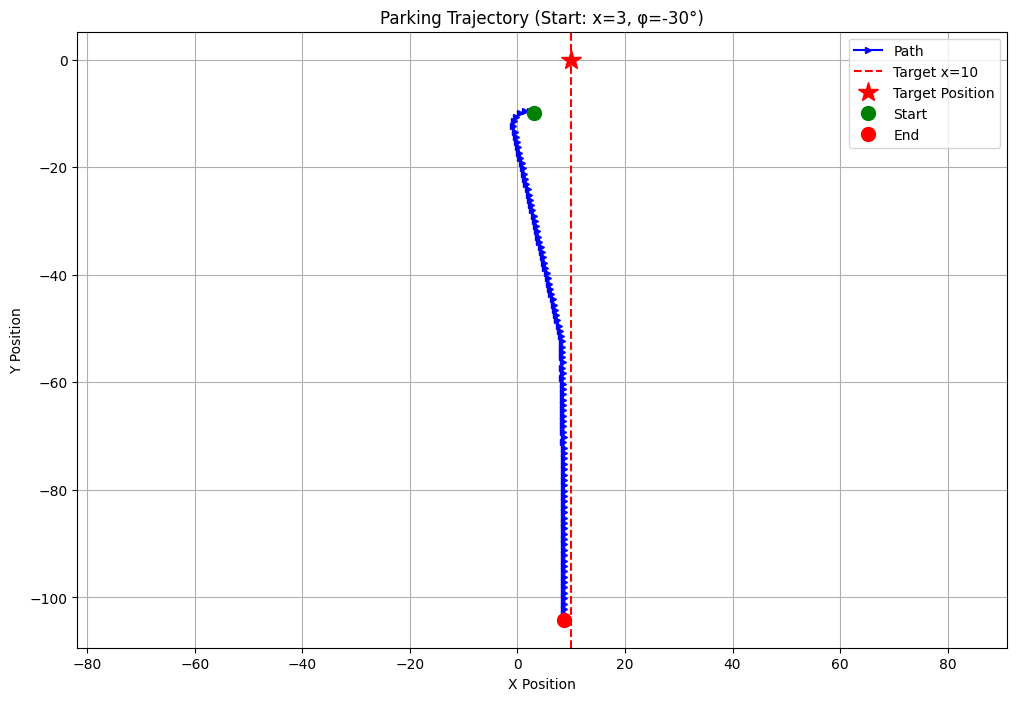

Target: x=10.00, φ=90.00
Final:  x=8.73, φ=89.86
Error:  x=1.27, φ=0.14

Testing from initial position: x=-10, φ=23°


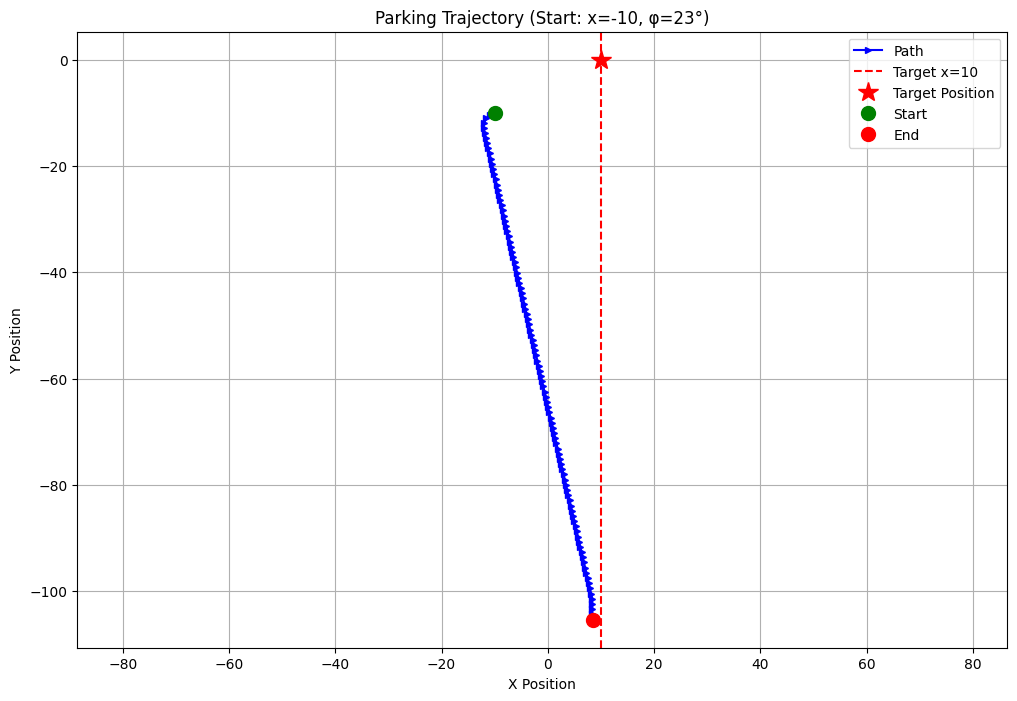

Target: x=10.00, φ=90.00
Final:  x=8.43, φ=87.05
Error:  x=1.57, φ=2.95

Testing from initial position: x=20, φ=-45°


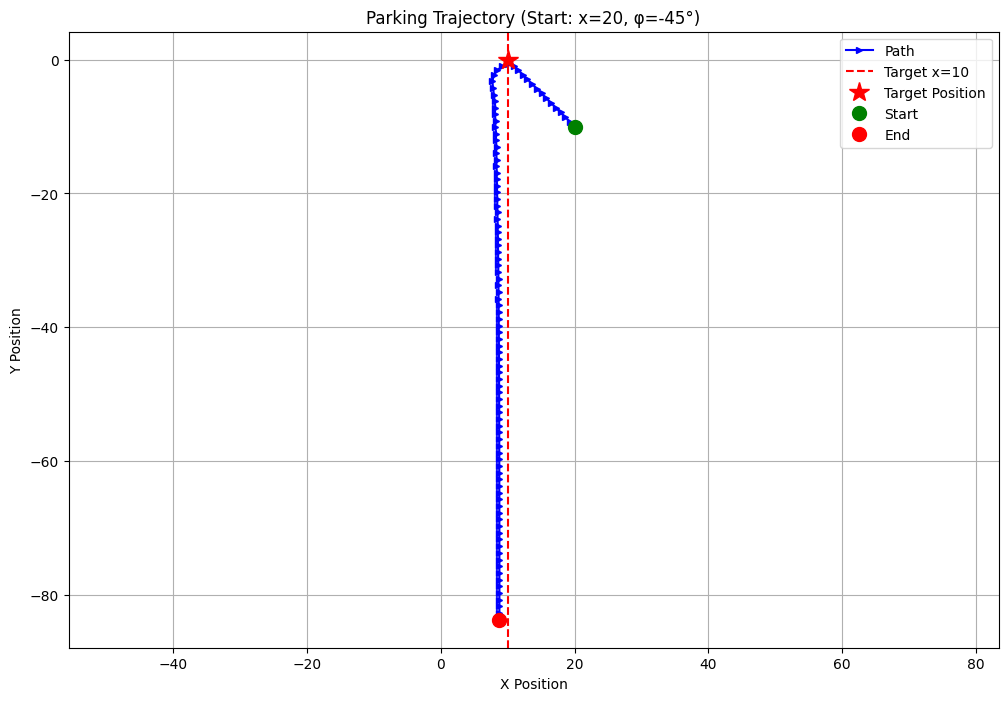

Target: x=10.00, φ=90.00
Final:  x=8.74, φ=90.08
Error:  x=1.26, φ=0.08

Testing from initial position: x=30, φ=-3°


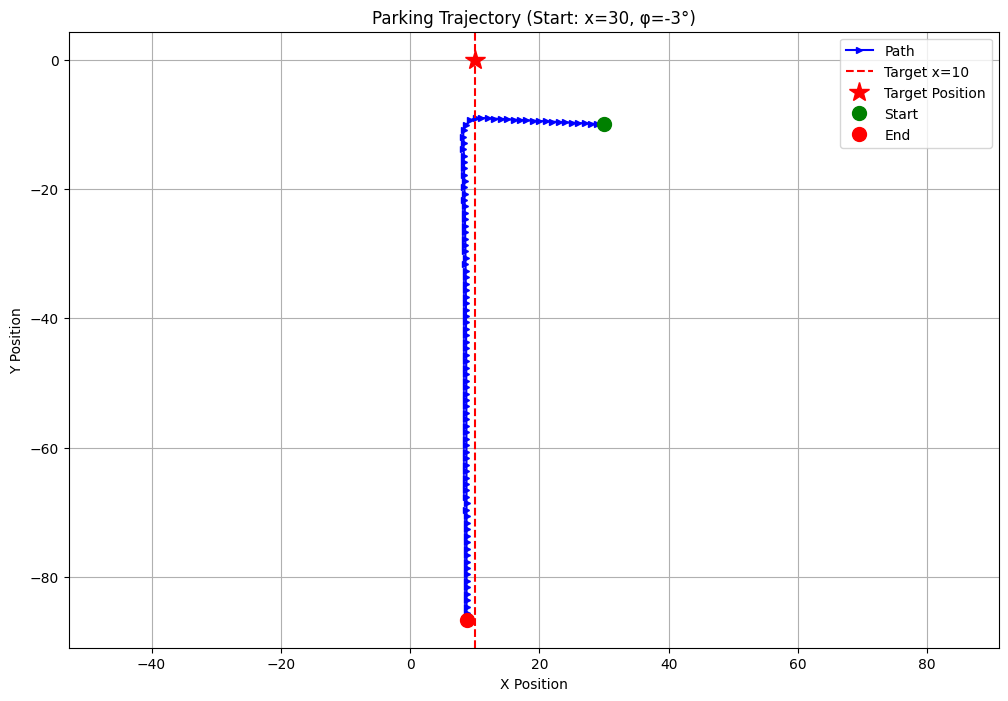

Target: x=10.00, φ=90.00
Final:  x=8.75, φ=89.97
Error:  x=1.25, φ=0.03

Testing from initial position: x=40, φ=180°


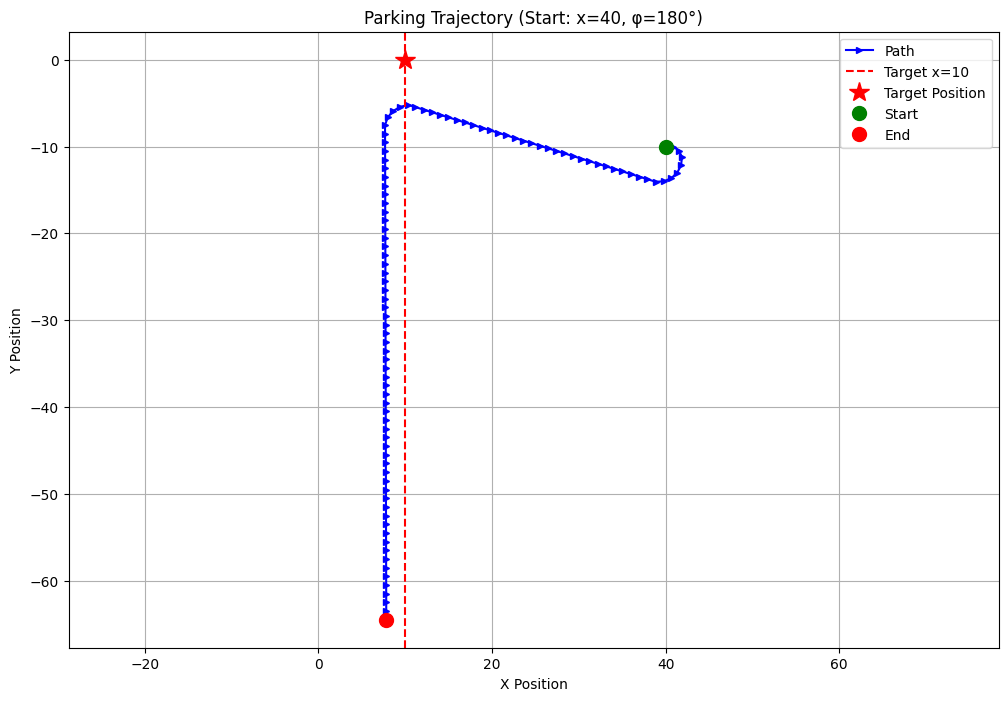

Target: x=10.00, φ=90.00
Final:  x=7.81, φ=90.14
Error:  x=2.19, φ=0.14

Testing from initial position: x=65, φ=-15°


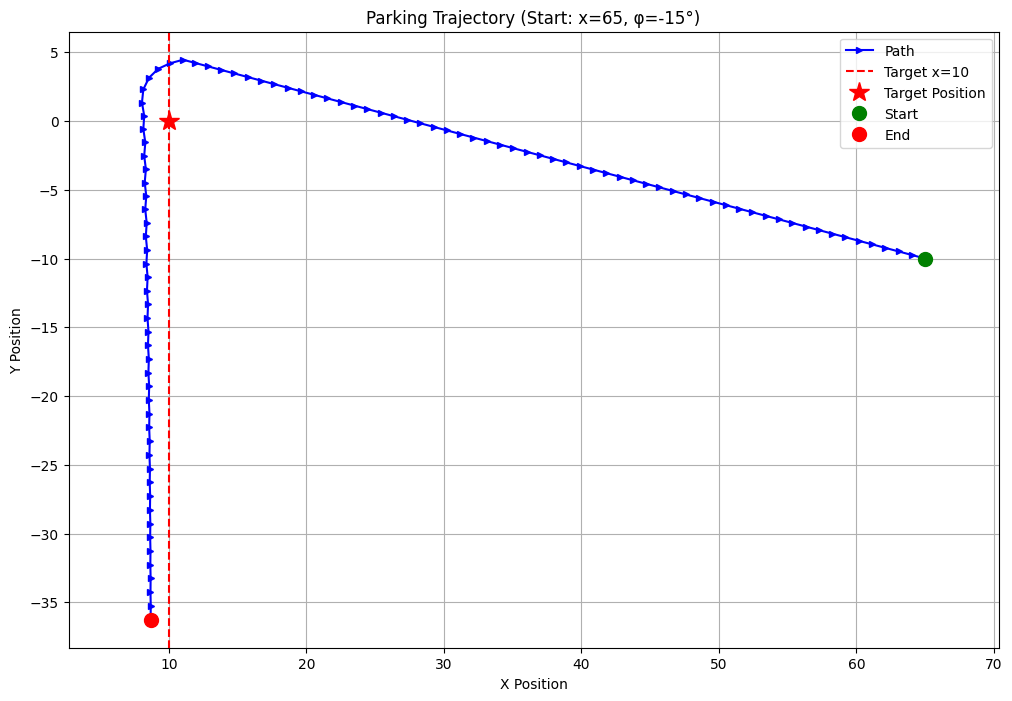

Target: x=10.00, φ=90.00
Final:  x=8.68, φ=90.94
Error:  x=1.32, φ=0.94

Testing from initial position: x=80, φ=100°


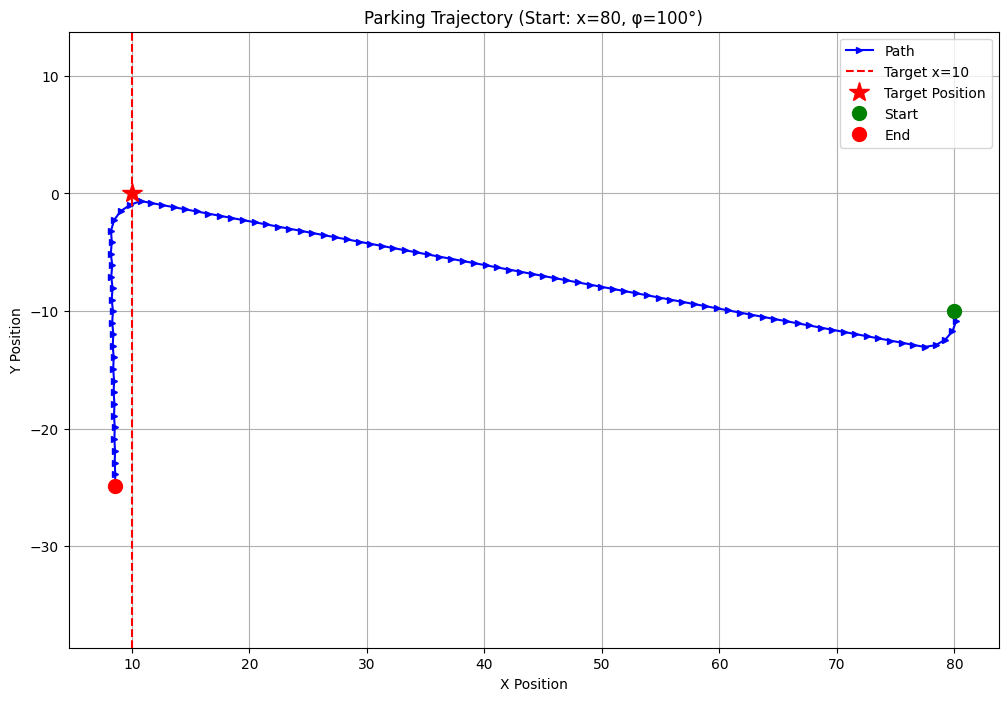

Target: x=10.00, φ=90.00
Final:  x=8.57, φ=92.36
Error:  x=1.43, φ=2.36


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

class FuzzyParkingController:
    def __init__(self):
        # Define universe variables
        x_range = np.arange(0, 21, 1)
        phi_range = np.arange(-90, 271, 1)
        theta_range = np.arange(-40, 41, 1)

        # Create fuzzy variables
        self.x = ctrl.Antecedent(x_range, 'x')
        self.phi = ctrl.Antecedent(phi_range, 'phi')
        self.theta = ctrl.Consequent(theta_range, 'theta')

        # Membership functions for x - focused around target x=10
        self.x['Left'] = fuzz.trimf(x_range, [0, 0, 10])
        self.x['Target'] = fuzz.trimf(x_range, [8, 10, 12])
        self.x['Right'] = fuzz.trimf(x_range, [10, 20, 20])

        # Membership functions for phi - focused around target phi=90
        self.phi['NegAngle'] = fuzz.trimf(phi_range, [-90, -45, 0])
        self.phi['SmallAngle'] = fuzz.trimf(phi_range, [0, 45, 90])
        self.phi['TargetAngle'] = fuzz.trimf(phi_range, [75, 90, 105])
        self.phi['LargeAngle'] = fuzz.trimf(phi_range, [90, 180, 270])

        # Membership functions for theta - optimized for parking maneuver
        self.theta['SharpLeft'] = fuzz.trimf(theta_range, [-40, -40, -20])
        self.theta['Left'] = fuzz.trimf(theta_range, [-30, -20, -10])
        self.theta['Zero'] = fuzz.trimf(theta_range, [-5, 0, 5])
        self.theta['Right'] = fuzz.trimf(theta_range, [10, 20, 30])
        self.theta['SharpRight'] = fuzz.trimf(theta_range, [20, 40, 40])

        # Simple, focused rules
        self.rules = [
            # Rules for x position correction
            ctrl.Rule(self.x['Left'] & self.phi['SmallAngle'], self.theta['Right']),
            ctrl.Rule(self.x['Left'] & self.phi['NegAngle'], self.theta['SharpRight']),
            ctrl.Rule(self.x['Right'] & self.phi['LargeAngle'], self.theta['SharpLeft']),
            ctrl.Rule(self.x['Right'] & self.phi['SmallAngle'], self.theta['Left']),

            # Rules for phi angle correction
            ctrl.Rule(self.x['Target'] & self.phi['NegAngle'], self.theta['SharpRight']),
            ctrl.Rule(self.x['Target'] & self.phi['SmallAngle'], self.theta['Right']),
            ctrl.Rule(self.x['Target'] & self.phi['LargeAngle'], self.theta['Left']),

            # Fine-tuning rules near target
            ctrl.Rule(self.x['Target'] & self.phi['TargetAngle'], self.theta['Zero']),
        ]

        # Create control system
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def get_steering_angle(self, x_pos, phi_angle):
        """Calculate steering angle based on current position and orientation"""
        # Normalize phi angle
        phi_angle = phi_angle % 360
        if phi_angle > 270:
            phi_angle -= 360

        self.simulation.input['x'] = x_pos
        self.simulation.input['phi'] = phi_angle

        try:
            self.simulation.compute()
            return self.simulation.output['theta']
        except:
            return 0

def simulate_parking(controller, initial_x, initial_phi, max_steps=100):
    """Simulate parking with ONLY reverse motion"""
    trajectory = []
    x, y, phi = initial_x, -10, initial_phi
    b = 2  # wheelbase
    direction = -1  # Force reverse motion only

    # Success criteria
    x_tolerance = 0.1
    phi_tolerance = 1.0

    for step in range(max_steps):
        trajectory.append((x, y, phi))

        # Check if target reached
        if (abs(x - 10) < x_tolerance and
            abs((phi % 360) - 90) < phi_tolerance):
            break

        # Get steering angle
        theta = controller.get_steering_angle(x, phi)

        # Update state with ONLY reverse motion
        theta_rad = np.radians(theta)
        phi_rad = np.radians(phi)

        x_new = x + direction * (np.cos(phi_rad + theta_rad) + np.sin(theta_rad) * np.sin(phi_rad))
        y_new = y + direction * (np.sin(phi_rad + theta_rad) - np.sin(theta_rad) * np.cos(phi_rad))
        phi_new = phi - direction * np.degrees(np.arcsin(2 * np.sin(theta_rad) / b))

        x, y, phi = x_new, y_new, phi_new

    return trajectory



def plot_trajectory(trajectory, initial_x, initial_phi):
    """Plot trajectory with target point emphasis"""
    x_coords = [point[0] for point in trajectory]
    y_coords = [point[1] for point in trajectory]

    plt.figure(figsize=(12, 8))

    # Plot trajectory
    plt.plot(x_coords, y_coords, 'b-', marker='>', markersize=4, label='Path')

    # Plot target position with emphasis
    plt.axvline(x=10, color='r', linestyle='--', label='Target x=10')
    plt.plot(10, 0, 'r*', markersize=15, label='Target Position')

    # Plot start point
    plt.plot(x_coords[0], y_coords[0], 'go', label='Start', markersize=10)

    # Plot end point
    plt.plot(x_coords[-1], y_coords[-1], 'ro', label='End', markersize=10)

    plt.grid(True)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Parking Trajectory (Start: x={initial_x}, φ={initial_phi}°)')
    plt.legend()
    plt.axis('equal')
    plt.show()

    # Print final position error
    final_pos = trajectory[-1]
    print(f"Target: x=10.00, φ=90.00")
    print(f"Final:  x={final_pos[0]:.2f}, φ={final_pos[2]:.2f}")
    print(f"Error:  x={abs(final_pos[0]-10):.2f}, φ={abs(final_pos[2]-90):.2f}")

# Update test cases to reflect only reverse motion
if __name__ == "__main__":
    controller = FuzzyParkingController()

    # Test cases with ONLY reverse motion
    test_positions = [

        (0,179),
        (1,26),
        (3,-30),
        (-10,23),
        (20,-45),
        (30,-3),
        (40,180),
        (65,-15),
        (80,100),
    ]

    for init_x, init_phi in test_positions:
        print(f"\nTesting from initial position: x={init_x}, φ={init_phi}°")
        trajectory = simulate_parking(controller, init_x, init_phi)
        plot_trajectory(trajectory, init_x, init_phi)

توابع عضویت

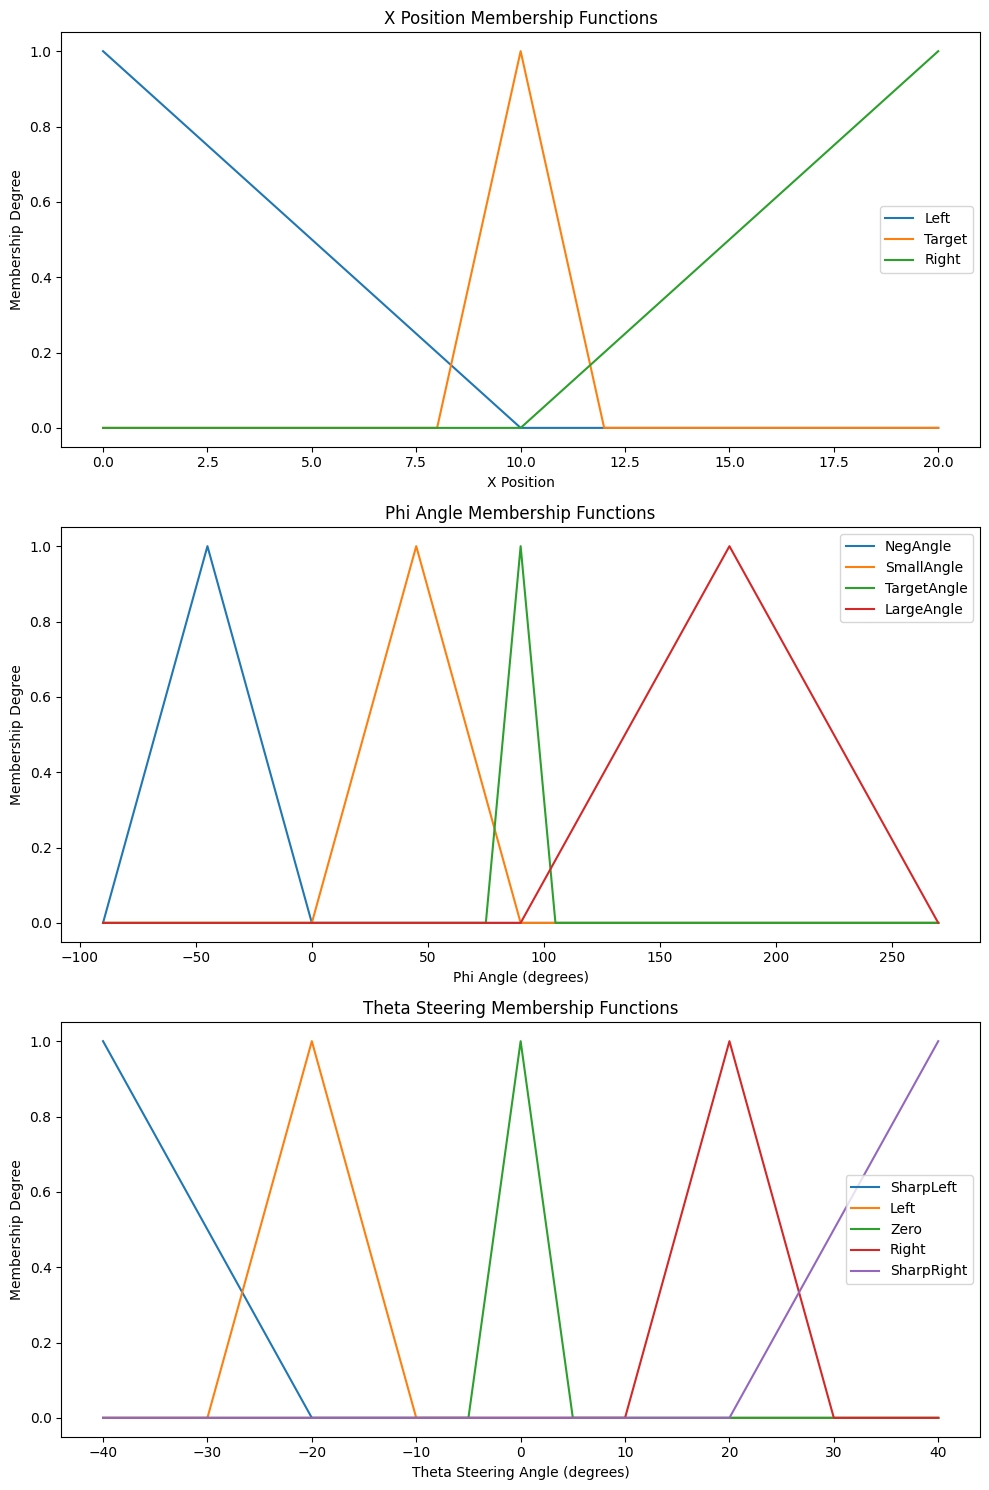

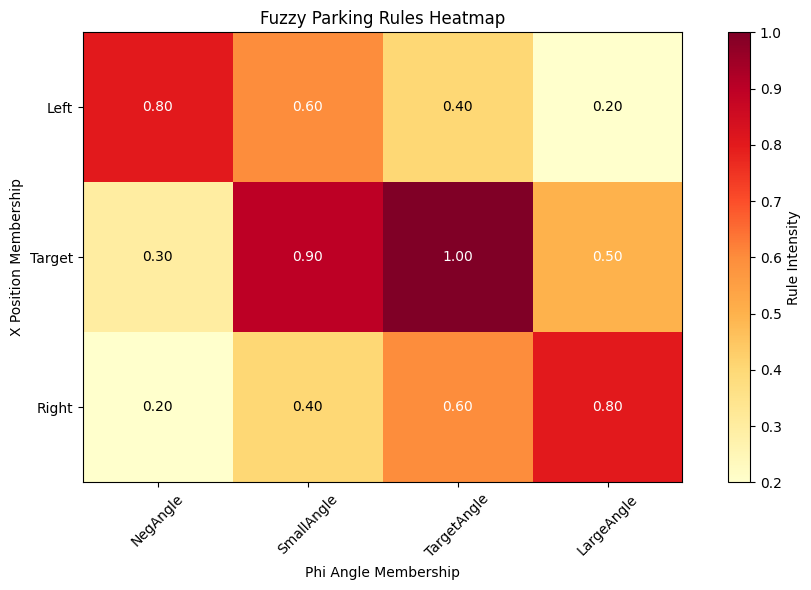

In [ ]:

def plot_membership_functions():
    # Define ranges
    x_range = np.arange(0, 21, 1)
    phi_range = np.arange(-90, 271, 1)
    theta_range = np.arange(-40, 41, 1)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.4)

    # X Position Membership Functions
    ax1.set_title('X Position Membership Functions')
    left_x = fuzz.trimf(x_range, [0, 0, 10])
    target_x = fuzz.trimf(x_range, [8, 10, 12])
    right_x = fuzz.trimf(x_range, [10, 20, 20])

    ax1.plot(x_range, left_x, label='Left')
    ax1.plot(x_range, target_x, label='Target')
    ax1.plot(x_range, right_x, label='Right')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Membership Degree')
    ax1.legend()

    # Phi Angle Membership Functions
    ax2.set_title('Phi Angle Membership Functions')
    neg_angle = fuzz.trimf(phi_range, [-90, -45, 0])
    small_angle = fuzz.trimf(phi_range, [0, 45, 90])
    target_angle = fuzz.trimf(phi_range, [75, 90, 105])
    large_angle = fuzz.trimf(phi_range, [90, 180, 270])

    ax2.plot(phi_range, neg_angle, label='NegAngle')
    ax2.plot(phi_range, small_angle, label='SmallAngle')
    ax2.plot(phi_range, target_angle, label='TargetAngle')
    ax2.plot(phi_range, large_angle, label='LargeAngle')
    ax2.set_xlabel('Phi Angle (degrees)')
    ax2.set_ylabel('Membership Degree')
    ax2.legend()

    # Theta Steering Membership Functions
    ax3.set_title('Theta Steering Membership Functions')
    sharp_left = fuzz.trimf(theta_range, [-40, -40, -20])
    left = fuzz.trimf(theta_range, [-30, -20, -10])
    zero = fuzz.trimf(theta_range, [-5, 0, 5])
    right = fuzz.trimf(theta_range, [10, 20, 30])
    sharp_right = fuzz.trimf(theta_range, [20, 40, 40])

    ax3.plot(theta_range, sharp_left, label='SharpLeft')
    ax3.plot(theta_range, left, label='Left')
    ax3.plot(theta_range, zero, label='Zero')
    ax3.plot(theta_range, right, label='Right')
    ax3.plot(theta_range, sharp_right, label='SharpRight')
    ax3.set_xlabel('Theta Steering Angle (degrees)')
    ax3.set_ylabel('Membership Degree')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def plot_fuzzy_rules_heatmap():
    # Simulated rule strengths (hypothetical)
    x_labels = ['Left', 'Target', 'Right']
    phi_labels = ['NegAngle', 'SmallAngle', 'TargetAngle', 'LargeAngle']

    # Create a heatmap of rule intensities
    rule_matrix = np.array([
        [0.8, 0.6, 0.4, 0.2],  # Left x
        [0.3, 0.9, 1.0, 0.5],  # Target x
        [0.2, 0.4, 0.6, 0.8]   # Right x
    ])

    plt.figure(figsize=(10, 6))
    plt.imshow(rule_matrix, cmap='YlOrRd', interpolation='nearest')
    plt.colorbar(label='Rule Intensity')
    plt.title('Fuzzy Parking Rules Heatmap')
    plt.xlabel('Phi Angle Membership')
    plt.ylabel('X Position Membership')

    plt.xticks(range(len(phi_labels)), phi_labels, rotation=45)
    plt.yticks(range(len(x_labels)), x_labels)

    # Add text annotations
    for i in range(len(x_labels)):
        for j in range(len(phi_labels)):
            plt.text(j, i, f'{rule_matrix[i, j]:.2f}',
                     ha='center', va='center',
                     color='black' if rule_matrix[i, j] < 0.5 else 'white')

    plt.tight_layout()
    plt.show()

# Run visualizations
if __name__ == "__main__":
    plot_membership_functions()
    plot_fuzzy_rules_heatmap()

محاسبه خطا

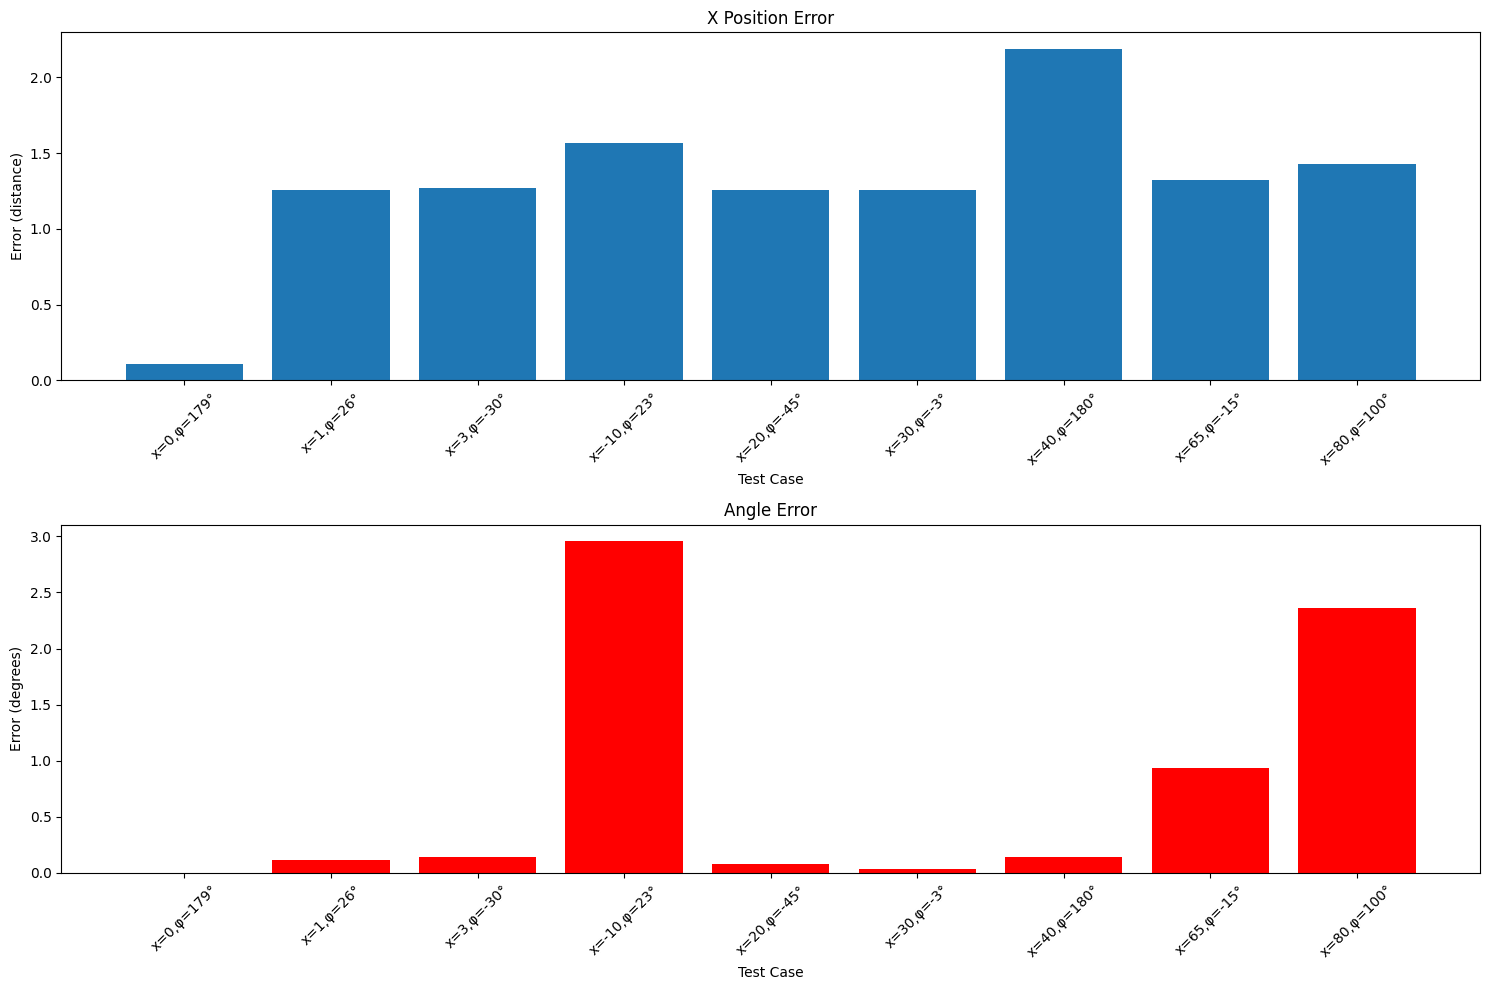


Error Statistics:
X Position - Mean Error: 1.2946
X Position - Max Error: 2.1887
Angle - Mean Error: 0.7517
Angle - Max Error: 2.9544


In [ ]:


def analyze_parking_errors():
    # Create controller
    controller = FuzzyParkingController()

    # Test positions
    test_positions = [
        (0, 179), (1, 26), (3, -30), (-10, 23),
        (20, -45), (30, -3), (40, 180), (65, -15), (80, 100)
    ]

    # Prepare error storage
    x_errors = []
    phi_errors = []
    initial_positions = []

    # Simulate parking for each position
    for init_x, init_phi in test_positions:
        trajectory = simulate_parking(controller, init_x, init_phi)
        final_pos = trajectory[-1]

        x_error = abs(final_pos[0] - 10)
        phi_error = abs(final_pos[2] - 90)

        x_errors.append(x_error)
        phi_errors.append(phi_error)
        initial_positions.append((init_x, init_phi))

    # Visualization
    plt.figure(figsize=(15, 10))

    # X Position Error Subplot
    plt.subplot(2, 1, 1)
    plt.bar(range(len(x_errors)), x_errors)
    plt.title('X Position Error')
    plt.xlabel('Test Case')
    plt.ylabel('Error (distance)')
    plt.xticks(range(len(initial_positions)),
               [f'x={x},φ={phi}°' for x, phi in initial_positions],
               rotation=45)

    # Phi Angle Error Subplot
    plt.subplot(2, 1, 2)
    plt.bar(range(len(phi_errors)), phi_errors, color='red')
    plt.title('Angle Error')
    plt.xlabel('Test Case')
    plt.ylabel('Error (degrees)')
    plt.xticks(range(len(initial_positions)),
               [f'x={x},φ={phi}°' for x, phi in initial_positions],
               rotation=45)

    plt.tight_layout()
    plt.show()

    # Statistical Analysis
    print("\nError Statistics:")
    print(f"X Position - Mean Error: {np.mean(x_errors):.4f}")
    print(f"X Position - Max Error: {np.max(x_errors):.4f}")
    print(f"Angle - Mean Error: {np.mean(phi_errors):.4f}")
    print(f"Angle - Max Error: {np.max(phi_errors):.4f}")

# Include the FuzzyParkingController and simulate_parking function from the previous implementation
# (Copy the entire previous implementation here)

if __name__ == "__main__":
    analyze_parking_errors()

پرسش سوم

سیستم Ball and Beam

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
import seaborn as sns

class SimplifiedANFISLayer(Layer):
    def __init__(self, num_membership_functions=3, **kwargs):
        super(SimplifiedANFISLayer, self).__init__(**kwargs)
        self.num_mf = num_membership_functions

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # Parameters for membership functions
        self.mf_centers = self.add_weight(
            name='mf_centers',
            shape=(input_dim, self.num_mf),
            initializer='uniform',
            trainable=True
        )

        self.mf_sigmas = self.add_weight(
            name='mf_sigmas',
            shape=(input_dim, self.num_mf),
            initializer='ones',
            trainable=True
        )

        # Consequent parameters
        self.consequents = self.add_weight(
            name='consequents',
            shape=(input_dim * self.num_mf, 1),
            initializer='uniform',
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        input_dim = tf.shape(inputs)[1]

        # Reshape inputs for broadcasting
        x = tf.expand_dims(inputs, axis=2)  # shape: (batch, input_dim, 1)

        # Calculate membership degrees
        diff = x - tf.expand_dims(self.mf_centers, axis=0)  # (batch, input_dim, num_mf)
        sigma = tf.abs(self.mf_sigmas) + 0.1
        membership = tf.exp(-tf.square(diff) / (2 * tf.expand_dims(sigma, axis=0) + 1e-10))

        # Flatten membership values
        flat_membership = tf.reshape(membership, [batch_size, -1])

        # Calculate output
        output = tf.matmul(flat_membership, self.consequents)

        return output

def create_model(input_dim, num_mf=3):
    inputs = Input(shape=(input_dim,))
    anfis_layer = SimplifiedANFISLayer(num_membership_functions=num_mf)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=anfis_layer)
    return model

def prepare_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length, 1])  # position is target
    return np.array(sequences), np.array(targets)

def analyze_ball_beam_system(data_path, seq_length=3):
    try:
        # Load and prepare data
        data = np.loadtxt(data_path)
        print("Data shape:", data.shape)

        # Normalize data
        scaler_X = MinMaxScaler(feature_range=(-1, 1))
        scaler_y = MinMaxScaler(feature_range=(-1, 1))

        # Normalize each column separately
        data_normalized = np.zeros_like(data)
        data_normalized[:, 0] = scaler_X.fit_transform(data[:, 0].reshape(-1, 1)).ravel()
        data_normalized[:, 1] = scaler_y.fit_transform(data[:, 1].reshape(-1, 1)).ravel()

        # Prepare sequences
        X, y = prepare_sequences(data_normalized, seq_length)
        print("Sequences shape:", X.shape)
        print("Targets shape:", y.shape)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Create and compile model
        model = create_model(input_dim=seq_length)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')

        # Train model
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = model.fit(
            X_train[:, :, 0],  # Use only angle data
            y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test[:, :, 0], y_test),
            callbacks=[early_stopping],
            verbose=1
        )

        # Make predictions
        y_pred = model.predict(X_test[:, :, 0])

        # Inverse transform predictions
        y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
        y_pred_original = scaler_y.inverse_transform(y_pred).ravel()

        # Calculate metrics
        mse = np.mean((y_test_original - y_pred_original) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_test_original - y_pred_original))

        # Plotting
        plt.figure(figsize=(15, 10))

        # Training history
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Predictions vs Actual
        plt.subplot(2, 2, 2)
        plt.plot(y_test_original[:100], label='Actual')
        plt.plot(y_pred_original[:100], label='Predicted')
        plt.title('Actual vs Predicted Values (First 100 samples)')
        plt.xlabel('Sample')
        plt.ylabel('Position')
        plt.legend()

        # Scatter plot
        plt.subplot(2, 2, 3)
        plt.scatter(y_test_original, y_pred_original, alpha=0.5)
        plt.plot([y_test_original.min(), y_test_original.max()],
                [y_test_original.min(), y_test_original.max()],
                'r--', lw=2)
        plt.title('Scatter Plot: Actual vs Predicted')
        plt.xlabel('Actual Position')
        plt.ylabel('Predicted Position')

        # Error distribution
        plt.subplot(2, 2, 4)
        errors = y_test_original - y_pred_original
        plt.hist(errors, bins=50)
        plt.title('Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

        print('\nPerformance Metrics:')
        print(f'MSE: {mse:.6f}')
        print(f'RMSE: {rmse:.6f}')
        print(f'MAE: {mae:.6f}')

        return model, history, (mse, rmse, mae)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None, None

# اجرای تحلیل
print("Starting analysis...")
data_path = 'ballbeam.dat'
model, history, metrics = analyze_ball_beam_system(data_path)

Starting analysis...
An error occurred: ballbeam.dat not found.


سیستم 2 steamgen

Starting power plant analysis...
Data shape: (9600, 9)

Analyzing output: drum_pressure
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2020 - val_loss: 0.1867
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1760 - val_loss: 0.1286
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1193 - val_loss: 0.1074
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1086 - val_loss: 0.1028
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1043 - val_loss: 0.1015
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1036 - val_loss: 0.1008
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1041 - val_loss: 0.0997
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1053 - val_loss: 0.0993
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1054 - val_loss: 0.0990
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0992 - val_loss: 0.0987
Epoch 11/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

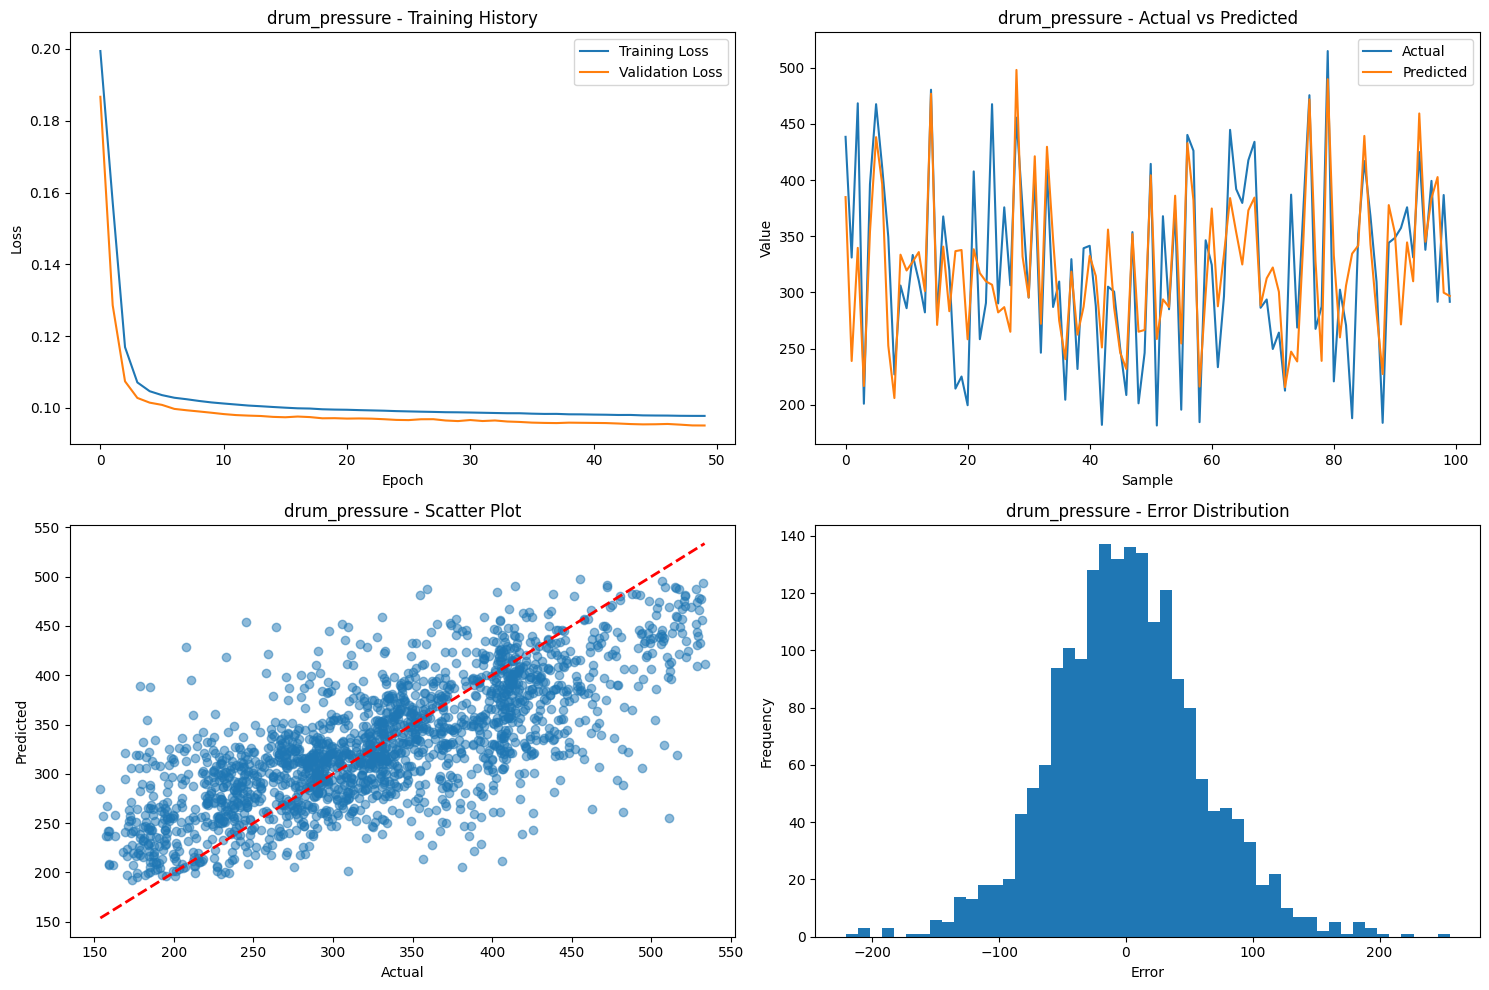


Metrics for drum_pressure:
MSE: 3441.556522
RMSE: 58.664781
MAE: 45.362743
R²: 0.538095

Analyzing output: excess_oxygen
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5916 - val_loss: 0.3459
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3096 - val_loss: 0.2448
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2242 - val_loss: 0.2088
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1964 - val_loss: 0.1955
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1894 - val_loss: 0.1908
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1913 - val_loss: 0.1889
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1872 - val_loss: 0.1875
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1837 - val_loss: 0.1862
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1814 - val_loss: 0.1842
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1783 - val_loss: 0.1812
Epoch 11/50
240/2

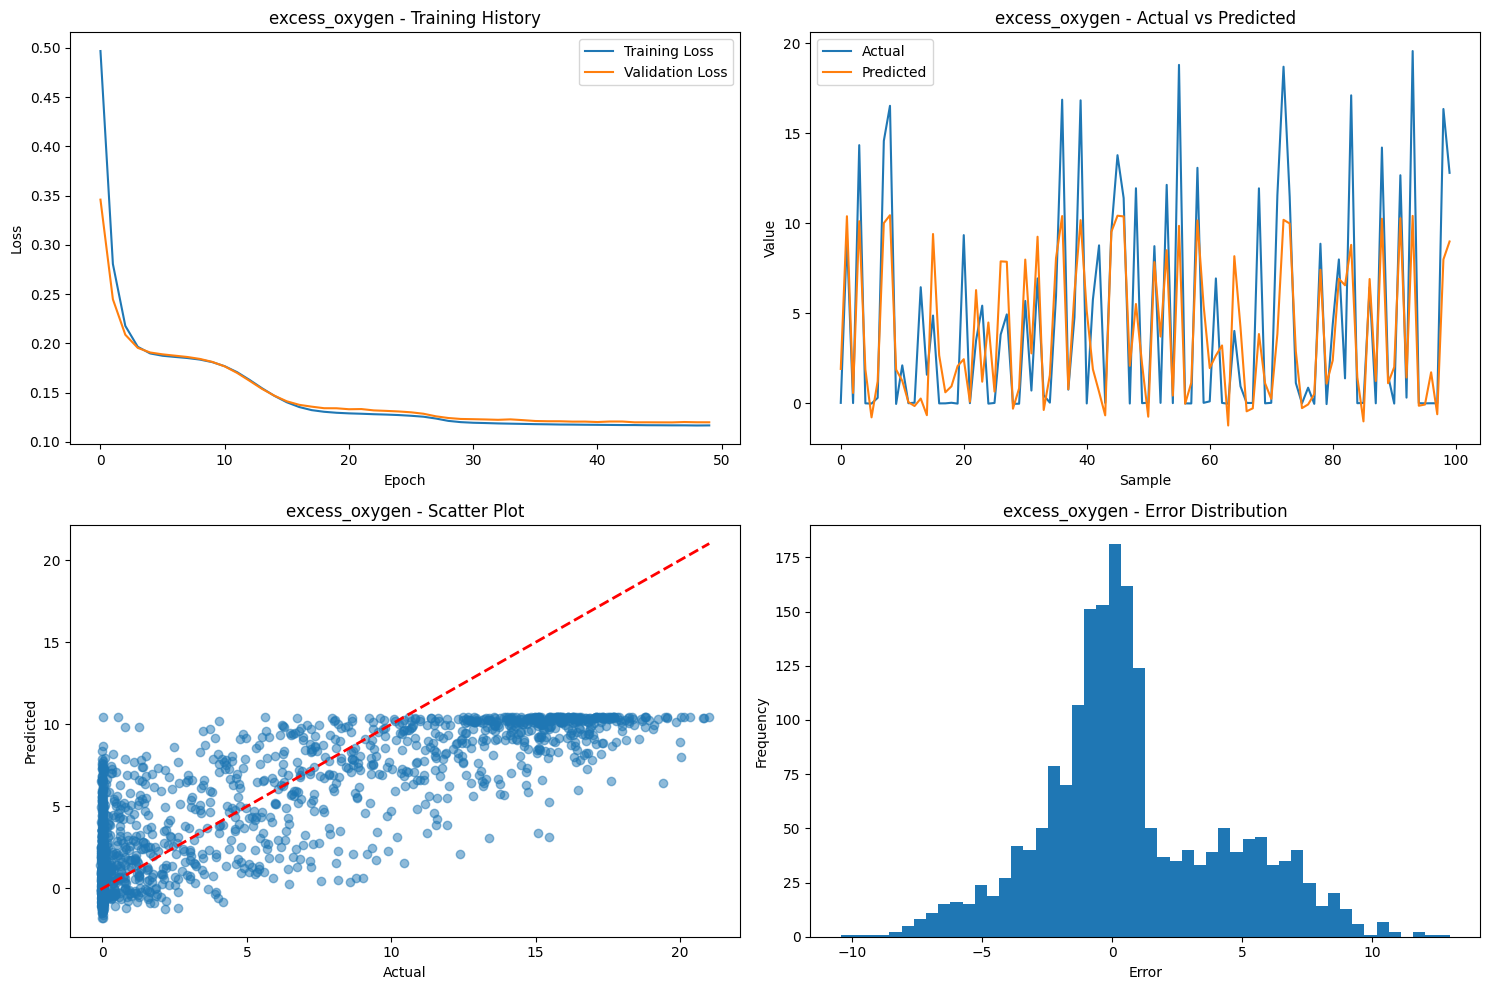


Metrics for excess_oxygen:
MSE: 13.305049
RMSE: 3.647609
MAE: 2.668757
R²: 0.658389

Analyzing output: water_level
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0719 - val_loss: 0.0599
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0605 - val_loss: 0.0422
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0443 - val_loss: 0.0375
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - val_loss: 0.0373
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0406 - val_loss: 0.0372
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0406 - val_loss: 0.0372
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - val_loss: 0.0371
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0395 - val_loss: 0.0371
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407 - val_loss: 0.0371
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0371
Epoch 11/50
240/240 ━━━

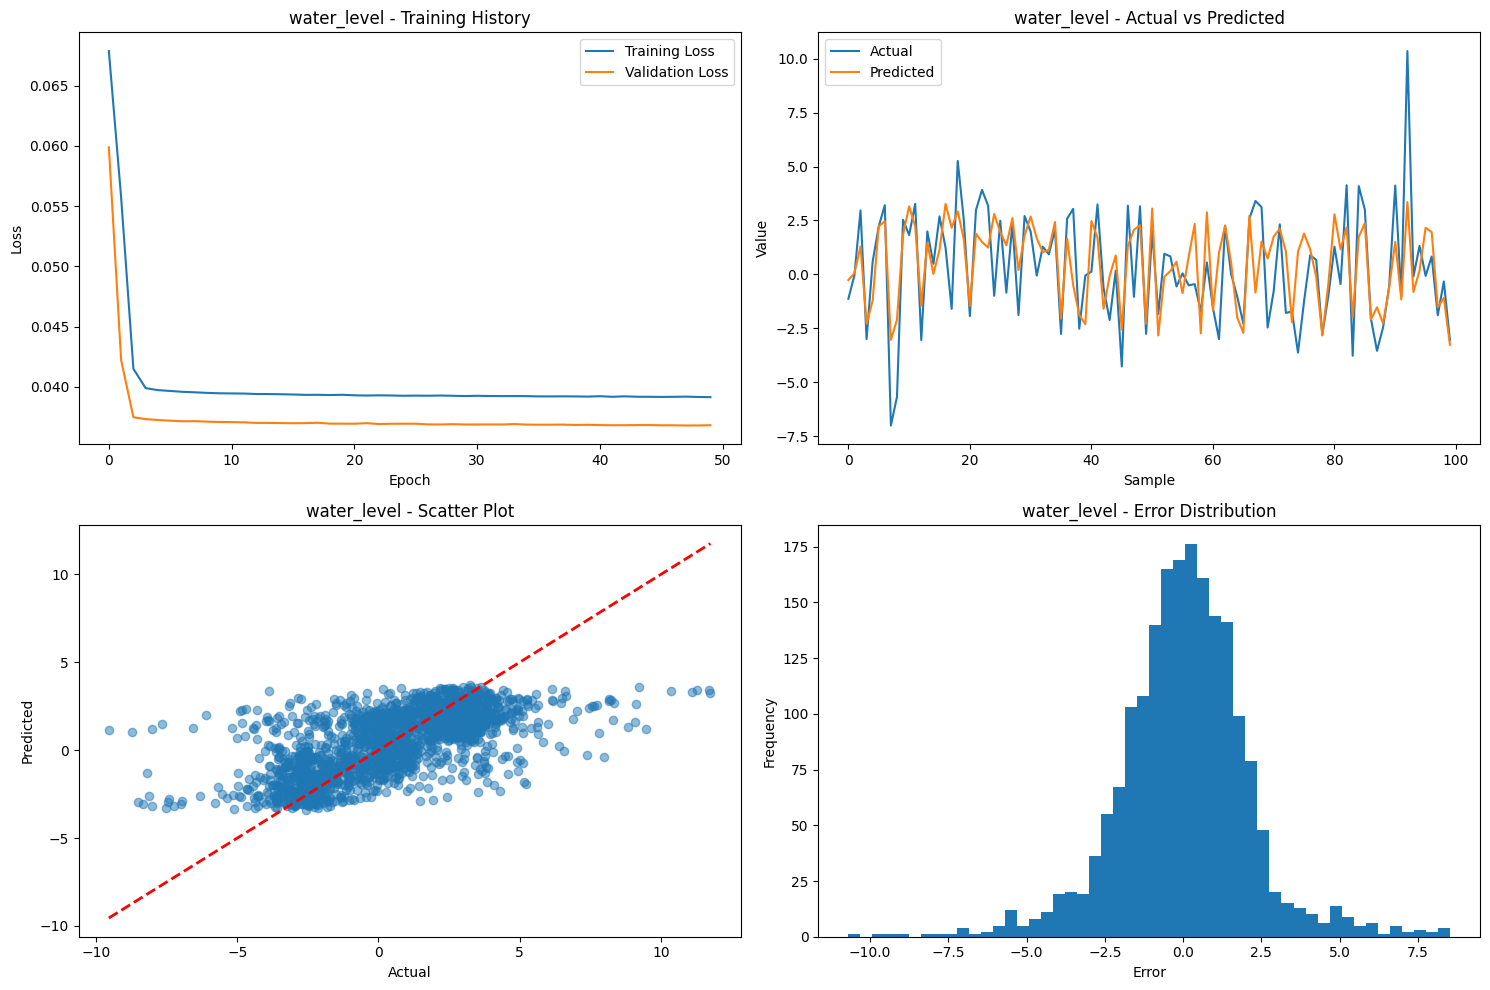


Metrics for water_level:
MSE: 4.387003
RMSE: 2.094517
MAE: 1.526109
R²: 0.429586

Analyzing output: steam_flow
Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2305 - val_loss: 0.1884
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1766 - val_loss: 0.1364
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1303 - val_loss: 0.1015
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1048 - val_loss: 0.0980
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1013 - val_loss: 0.0969
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1050 - val_loss: 0.0958
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0999 - val_loss: 0.0943
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0996 - val_loss: 0.0929
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0979 - val_loss: 0.0919
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0963 - val_loss: 0.0914
Epoch 11/50
240/240 ━━━━━━━

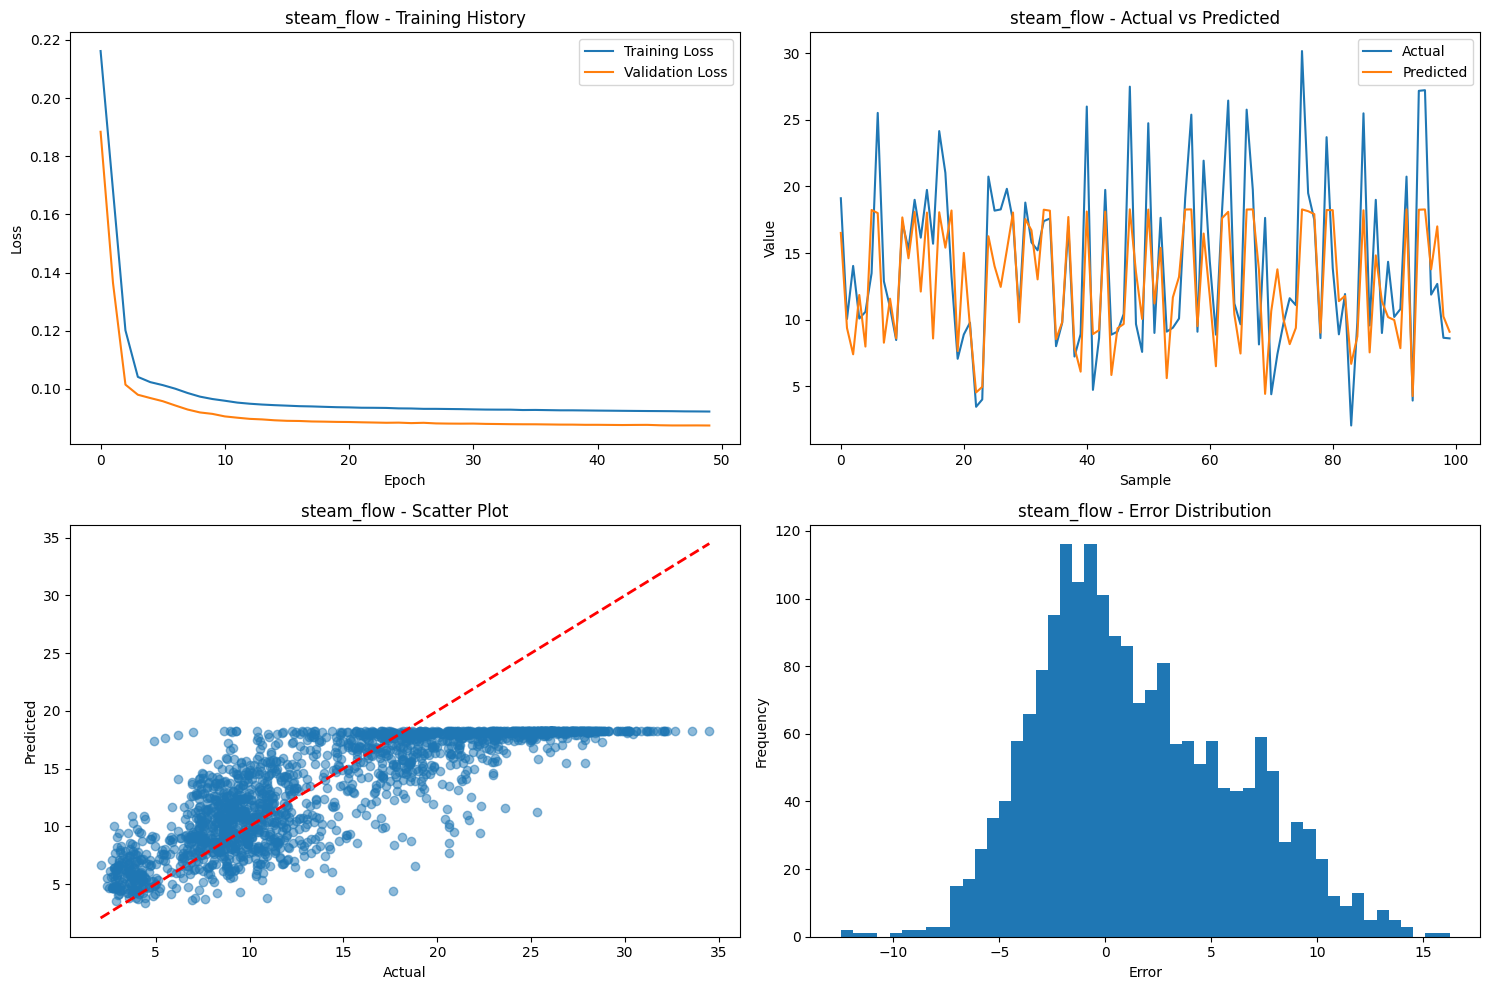


Metrics for steam_flow:
MSE: 23.205295
RMSE: 4.817187
MAE: 3.769709
R²: 0.591476


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input

class PowerPlantANFISLayer(Layer):
    def __init__(self, num_mf=3, **kwargs):
        super(PowerPlantANFISLayer, self).__init__(**kwargs)
        self.num_mf = num_mf

    def build(self, input_shape):
        input_dim = input_shape[-1]

        # پارامترهای توابع عضویت برای هر ورودی
        self.mf_centers = self.add_weight(
            name='mf_centers',
            shape=(input_dim, self.num_mf),
            initializer='uniform',
            trainable=True
        )

        self.mf_sigmas = self.add_weight(
            name='mf_sigmas',
            shape=(input_dim, self.num_mf),
            initializer='ones',
            trainable=True
        )

        # پارامترهای نتیجه برای هر خروجی
        self.consequents = self.add_weight(
            name='consequents',
            shape=(self.num_mf, 1),
            initializer='uniform',
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # محاسبه درجات عضویت
        x = tf.expand_dims(inputs, axis=2)
        diff = x - tf.expand_dims(self.mf_centers, axis=0)
        sigma = tf.abs(self.mf_sigmas) + 0.1
        membership = tf.exp(-tf.square(diff) / (2 * tf.expand_dims(sigma, axis=0) + 1e-10))

        # ترکیب درجات عضویت
        flat_membership = tf.reduce_prod(membership, axis=1)

        # محاسبه خروجی
        output = tf.matmul(flat_membership, self.consequents)

        return output

def create_miso_model(input_dim, num_mf=3):
    """ایجاد مدل MISO (Multiple Input Single Output)"""
    inputs = Input(shape=(input_dim,))
    anfis_layer = PowerPlantANFISLayer(num_mf=num_mf)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=anfis_layer)
    return model

def prepare_data(data, input_cols, output_col, lookback=5):
    """آماده‌سازی داده‌ها برای آموزش"""
    X = data[input_cols].values
    y = data[output_col].values

    X_seq, y_seq = [], []
    for i in range(len(data) - lookback):
        X_seq.append(X[i:i + lookback])
        y_seq.append(y[i + lookback])

    return np.array(X_seq), np.array(y_seq)

def analyze_power_plant(data_path):
    try:
        # خواندن داده‌ها
        data = pd.read_csv(data_path, delimiter='\s+', header=None)
        data.columns = ['time', 'fuel', 'air', 'level_ref', 'disturbance',
                        'drum_pressure', 'excess_oxygen', 'water_level', 'steam_flow']

        print("Data shape:", data.shape)

        # تعریف ورودی‌ها و خروجی‌ها
        input_features = ['fuel', 'air', 'level_ref', 'disturbance']
        output_features = ['drum_pressure', 'excess_oxygen', 'water_level', 'steam_flow']

        # نرمال‌سازی داده‌ها
        scaler_X = MinMaxScaler(feature_range=(-1, 1))
        scaler_y = MinMaxScaler(feature_range=(-1, 1))

        data_normalized = data.copy()
        data_normalized[input_features] = scaler_X.fit_transform(data[input_features])

        # نتایج برای هر خروجی
        results = {}
        metrics = {}

        for output in output_features:
            print(f"\nAnalyzing output: {output}")

            # نرمال‌سازی خروجی خاص
            data_normalized[output] = scaler_y.fit_transform(data[[output]])

            # آماده‌سازی داده‌ها
            X, y = prepare_data(data_normalized, input_features, output, lookback=5)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # ایجاد و آموزش مدل
            model = create_miso_model(input_dim=X_train.shape[-1])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss='mse')

            # تنظیم callbacks
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )

            # آموزش مدل
            history = model.fit(
                X_train[:, -1, :],  # استفاده از آخرین گام زمانی
                y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test[:, -1, :], y_test),
                callbacks=[early_stopping],
                verbose=1
            )

            # پیش‌بینی
            y_pred = model.predict(X_test[:, -1, :])

            # برگرداندن به مقیاس اصلی
            y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))[:, 0]
            y_pred_original = scaler_y.inverse_transform(y_pred)[:, 0]

            # محاسبه معیارها
            mse = np.mean((y_test_original - y_pred_original) ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(y_test_original - y_pred_original))
            r2 = 1 - np.sum((y_test_original - y_pred_original)**2) / np.sum((y_test_original - np.mean(y_test_original))**2)

            # ذخیره نتایج
            results[output] = {
                'model': model,
                'history': history,
                'predictions': y_pred_original,
                'actual': y_test_original
            }

            metrics[output] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }

            # رسم نمودارها
            plt.figure(figsize=(15, 10))

            # نمودار Loss
            plt.subplot(2, 2, 1)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'{output} - Training History')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()

            # نمودار پیش‌بینی
            plt.subplot(2, 2, 2)
            plt.plot(y_test_original[:100], label='Actual')
            plt.plot(y_pred_original[:100], label='Predicted')
            plt.title(f'{output} - Actual vs Predicted')
            plt.xlabel('Sample')
            plt.ylabel('Value')
            plt.legend()

            # نمودار پراکندگی
            plt.subplot(2, 2, 3)
            plt.scatter(y_test_original, y_pred_original, alpha=0.5)
            plt.plot([y_test_original.min(), y_test_original.max()],
                     [y_test_original.min(), y_test_original.max()],
                     'r--', lw=2)
            plt.title(f'{output} - Scatter Plot')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')

            # نمودار توزیع خطا
            plt.subplot(2, 2, 4)
            error = y_test_original - y_pred_original
            plt.hist(error, bins=50)
            plt.title(f'{output} - Error Distribution')
            plt.xlabel('Error')
            plt.ylabel('Frequency')

            plt.tight_layout()
            plt.show()

            # چاپ معیارها
            print(f'\nMetrics for {output}:')
            print(f'MSE: {mse:.6f}')
            print(f'RMSE: {rmse:.6f}')
            print(f'MAE: {mae:.6f}')
            print(f'R²: {r2:.6f}')

        return results, metrics

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

# اجرای تحلیل
print("Starting power plant analysis...")
data_path = 'steamgen.dat'
results, metrics = analyze_power_plant(data_path)


پرسش چهارم

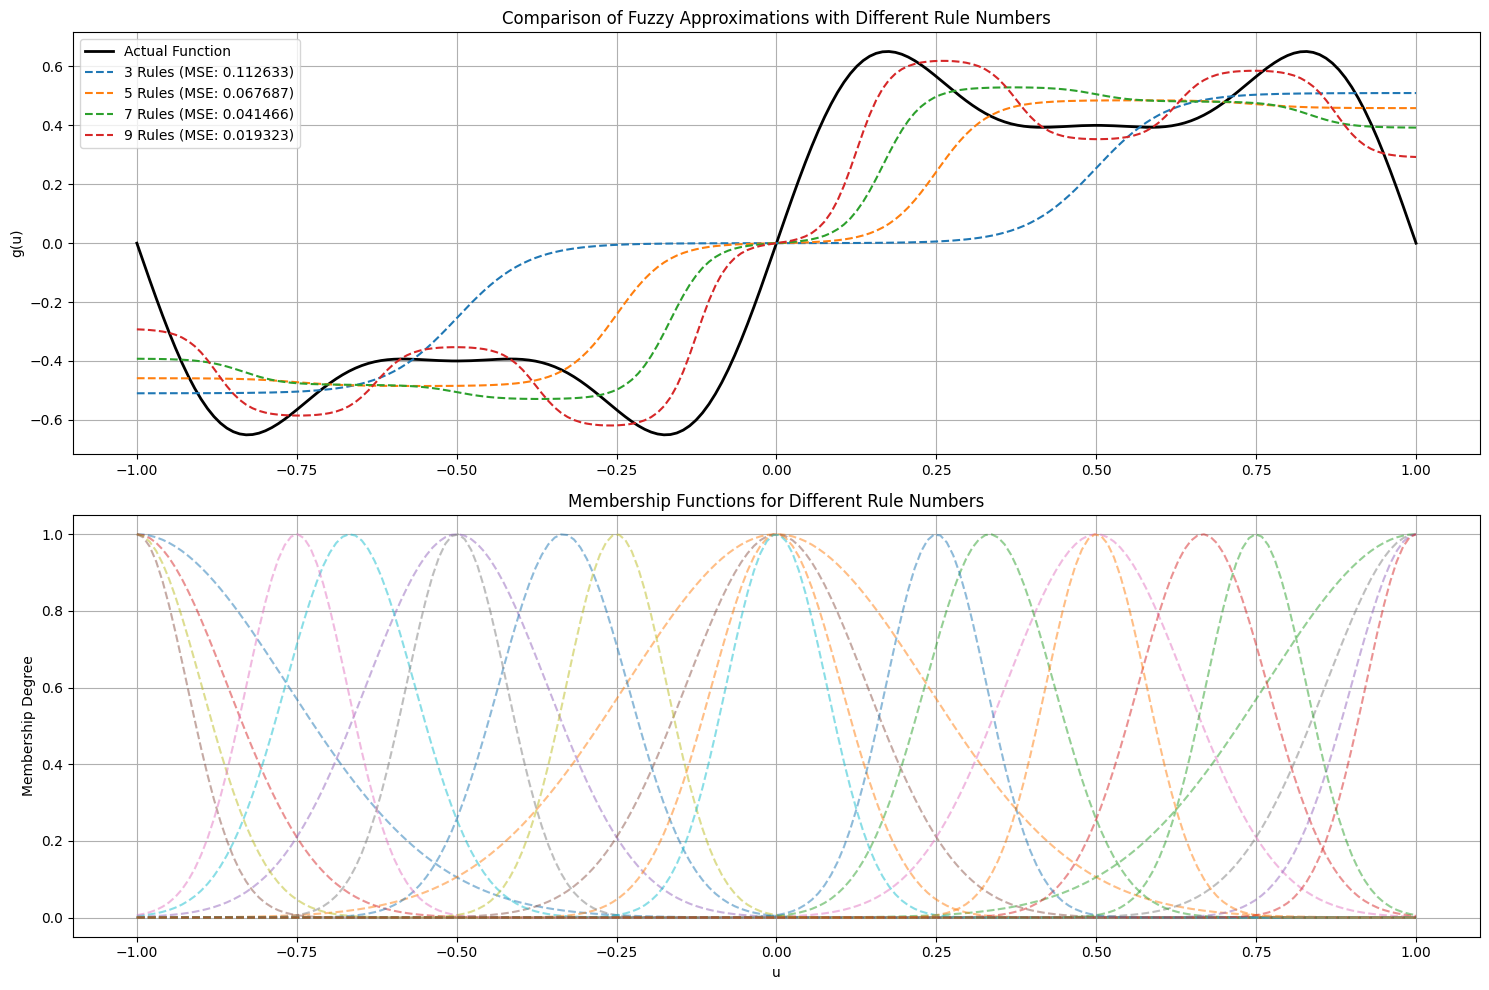


MSE Comparison:
Rules: 3, MSE: 0.112633
Rules: 5, MSE: 0.067687
Rules: 7, MSE: 0.041466
Rules: 9, MSE: 0.019323


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def g_actual(u):
    return 0.6 * np.sin(np.pi * u) + 0.3 * np.sin(3 * np.pi * u) + 0.1 * np.sin(5 * np.pi * u)

class TSFuzzyModel:
    def __init__(self, n_rules, input_range):
        self.n_rules = n_rules
        self.centers = np.linspace(input_range[0], input_range[1], n_rules)
        self.sigmas = np.ones(n_rules) * (input_range[1] - input_range[0]) / (2 * n_rules)
        self.g_params = np.zeros(n_rules)

    def membership(self, x):
        return np.exp(-((x[:, np.newaxis] - self.centers)**2) / (self.sigmas**2))

    def predict(self, x):
        memberships = self.membership(x)
        numerator = np.sum(memberships * self.g_params, axis=1)
        denominator = np.sum(memberships, axis=1)
        return numerator / (denominator + 1e-10)

    def train(self, x_train, y_train):
        def loss(params):
            self.g_params = params
            y_pred = self.predict(x_train)
            return np.mean((y_train - y_pred)**2)

        result = minimize(loss, np.random.randn(self.n_rules), method='BFGS')
        self.g_params = result.x
        return result.fun


x = np.linspace(-1, 1, 200)
y_true = g_actual(x)


rule_numbers = [3, 5, 7, 9]
models = []
mse_scores = []

plt.figure(figsize=(15, 10))

# نمایش خروجی
plt.subplot(2, 1, 1)
plt.plot(x, y_true, 'k-', label='Actual Function', linewidth=2)

for n_rules in rule_numbers:
    model = TSFuzzyModel(n_rules, [-1, 1])
    mse = model.train(x, y_true)
    y_pred = model.predict(x)

    plt.plot(x, y_pred, '--', label=f'{n_rules} Rules (MSE: {mse:.6f})')
    models.append(model)
    mse_scores.append(mse)

plt.grid(True)
plt.legend()
plt.title('Comparison of Fuzzy Approximations with Different Rule Numbers')
plt.ylabel('g(u)')

# نمایش قواعد فازی
plt.subplot(2, 1, 2)
for i, model in enumerate(models):
    memberships = model.membership(x)
    for j in range(model.n_rules):
        plt.plot(x, memberships[:, j], '--', alpha=0.5)

plt.grid(True)
plt.title('Membership Functions for Different Rule Numbers')
plt.xlabel('u')
plt.ylabel('Membership Degree')

plt.tight_layout()
plt.show()

# MSE
print("\nMSE Comparison:")
for n_rules, mse in zip(rule_numbers, mse_scores):
    print(f"Rules: {n_rules}, MSE: {mse:.6f}")

In [ ]:
سوال پنجم

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf
from tensorflow import keras
# import warnings
# warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']


In [ ]:
def load_and_preprocess_data(file_path):
    """بارگذاری و پیش‌پردازش داده‌ها"""
    try:
        # خواندن داده‌ها
        print("Loading data...")
        df = pd.read_excel(file_path)

        # حذف ستون‌های تاریخ و زمان
        df = df.drop(['Date', 'Time'], axis=1, errors='ignore')

        # حذف مقادیر -200 (مقادیر گمشده)
        df = df.replace(-200, np.nan)

        # انتخاب فقط ستون‌های عددی
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df = df[numeric_columns]

        # حذف سطرهای با مقادیر گمشده
        df_cleaned = df.dropna()

        print(f"Shape after cleaning: {df_cleaned.shape}")
        print("Available columns:", df_cleaned.columns.tolist())

        # انتخاب ویژگی‌ها و هدف
        target_col ='NO2(GT)'
        feature_columns = [col for col in df_cleaned.columns if col != target_col]
        X = df_cleaned[feature_columns].astype(float)
        y = df_cleaned[target_col].astype(float)

        print(f"Number of features: {X.shape[1]}")
        print(f"Number of samples: {X.shape[0]}")


        return X, y

    except Exception as e:
        print(f"Error in data loading and preprocessing: {str(e)}")
        raise

In [ ]:
def create_and_train_models(X, y):
    try:
        # تقسیم داده‌ها (60-20-20)
        X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

        # نرمال‌سازی
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # مدل RBF
        print("\nTraining RBF model...")
        rbf_kernel = RBF(length_scale=1.0)
        rbf_model = GaussianProcessRegressor(kernel=rbf_kernel, random_state=42)
        rbf_model.fit(X_train_scaled, y_train)
        rbf_predictions = rbf_model.predict(X_test_scaled)

        # مدل ANFIS
        print("\nTraining ANFIS model...")
        anfis_model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(1)
        ])

        anfis_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        history = anfis_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=1
        )

        anfis_predictions = anfis_model.predict(X_test_scaled).flatten()

        return rbf_predictions, anfis_predictions, y_test, history, X_test_scaled

    except Exception as e:
        print(f"Error in model training: {str(e)}")
        raise


In [ ]:

def enhanced_evaluate_and_visualize(rbf_predictions, anfis_predictions, y_test, history, X_test):
    """ارزیابی و نمایش نتایج با نمودارهای تحلیلی بیشتر"""
    try:
        # 1. ارزیابی مدل‌ها
        def evaluate_model(y_true, y_pred, model_name):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            print(f'\nResults for {model_name}:')
            print(f'MSE: {mse:.6f}')
            print(f'RMSE: {rmse:.6f}')
            print(f'MAE: {mae:.6f}')
            print(f'R2 Score: {r2:.6f}')

            return mse, rmse, mae, r2

        rbf_metrics = evaluate_model(y_test, rbf_predictions, "RBF")
        anfis_metrics = evaluate_model(y_test, anfis_predictions, "ANFIS")

        # 2. نمودار اصلی مقایسه‌ای
        plt.figure(figsize=(20, 15))

        # 2.1 مقایسه پیش‌بینی‌ها
        plt.subplot(321)
        plt.scatter(y_test, rbf_predictions, alpha=0.5, label='RBF', color='blue')
        plt.scatter(y_test, anfis_predictions, alpha=0.5, label='ANFIS', color='red')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.xlabel('Real values')
        plt.ylabel('Predicted values')
        plt.legend()
        plt.title('Compare predictions with actual values')

        # 2.2 توزیع خطا
        plt.subplot(322)
        rbf_errors = rbf_predictions - y_test
        anfis_errors = anfis_predictions - y_test
        sns.kdeplot(data=rbf_errors, label='RBF', color='blue')
        sns.kdeplot(data=anfis_errors, label='ANFIS', color='red')
        plt.xlabel('Prediction error')
        plt.ylabel('Density')
        plt.legend()
        plt.title('Prediction error distribution')

        # 2.3 نمودار جعبه‌ای خطاها
        plt.subplot(323)
        plt.boxplot([rbf_errors, anfis_errors], labels=['RBF', 'ANFIS'])
        plt.ylabel('Prediction error')
        plt.title('Comparison of error distributions')

        # 2.4 مقایسه سری زمانی
        plt.subplot(324)
        plt.plot(y_test[:100], label='Real', color='green', alpha=0.7)
        plt.plot(rbf_predictions[:100], label='RBF', color='blue', alpha=0.7)
        plt.plot(anfis_predictions[:100], label='ANFIS', color='red', alpha=0.7)
        plt.xlabel('Sample')
        plt.ylabel('Amount')
        plt.legend()
        plt.title('Time series comparison (first 100 samples)')

        # 2.5 نمودار پراکندگی خطاها
        plt.subplot(325)
        plt.scatter(y_test, abs(rbf_errors), alpha=0.5, label='RBF', color='blue')
        plt.scatter(y_test, abs(anfis_errors), alpha=0.5, label='ANFIS', color='red')
        plt.xlabel('Real values')
        plt.ylabel('Absolute value of error')
        plt.legend()
        plt.title('Dispersion of errors relative to true values')

        # 2.6 هیستوگرام خطاها
        plt.subplot(326)
        plt.hist(rbf_errors, bins=50, alpha=0.5, label='RBF', color='blue')
        plt.hist(anfis_errors, bins=50, alpha=0.5, label='ANFIS', color='red')
        plt.xlabel('Prediction error')
        plt.ylabel('Abundance')
        plt.legend()
        plt.title('Histogram of errors')

        plt.tight_layout()
        plt.show()

        # 3. نمودار روند آموزش ANFIS
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Traning error')
        plt.plot(history.history['val_loss'], label='Validation error')
        plt.xlabel('Repetition')
        plt.ylabel('Error')
        plt.title('ANFIS training process')
        plt.legend()
        plt.show()

        # 4. نمایش آماری خطاها
        print("\nآمار توصیفی خطاها:")
        print("\nRBF Error Statistics:")
        print(pd.Series(rbf_errors).describe())
        print("\nANFIS Error Statistics:")
        print(pd.Series(anfis_errors).describe())

        # 5. درصد خطاهای بزرگ
        large_error_threshold = np.std(y_test)
        rbf_large_errors = np.sum(np.abs(rbf_errors) > large_error_threshold) / len(rbf_errors) * 100
        anfis_large_errors = np.sum(np.abs(anfis_errors) > large_error_threshold) / len(anfis_errors) * 100

        print(f"\nدرصد خطاهای بزرگ (بیشتر از یک انحراف معیار):")
        print(f"RBF: {rbf_large_errors:.2f}%")
        print(f"ANFIS: {anfis_large_errors:.2f}%")

    except Exception as e:
        print(f"Error in evaluation and visualization: {str(e)}")
        raise


Loading data...
Shape after cleaning: (827, 13)
Available columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Number of features: 12
Number of samples: 827

Training RBF model...

Training ANFIS model...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 10649.7725 - mae: 98.5313 - val_loss: 10971.8486 - val_mae: 99.8544
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11532.2725 - mae: 103.2342 - val_loss: 10906.0537 - val_mae: 99.7007
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10431.6914 - mae: 98.0982 - val_loss: 10862.3418 - val_mae: 99.6963
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10875.6250 - mae: 100.7240 - val_loss: 10824.9189 - val_mae: 99.7217
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10755.0410 - mae: 100.0217 - val_loss: 10771.9922 - val_mae: 99.6605
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/

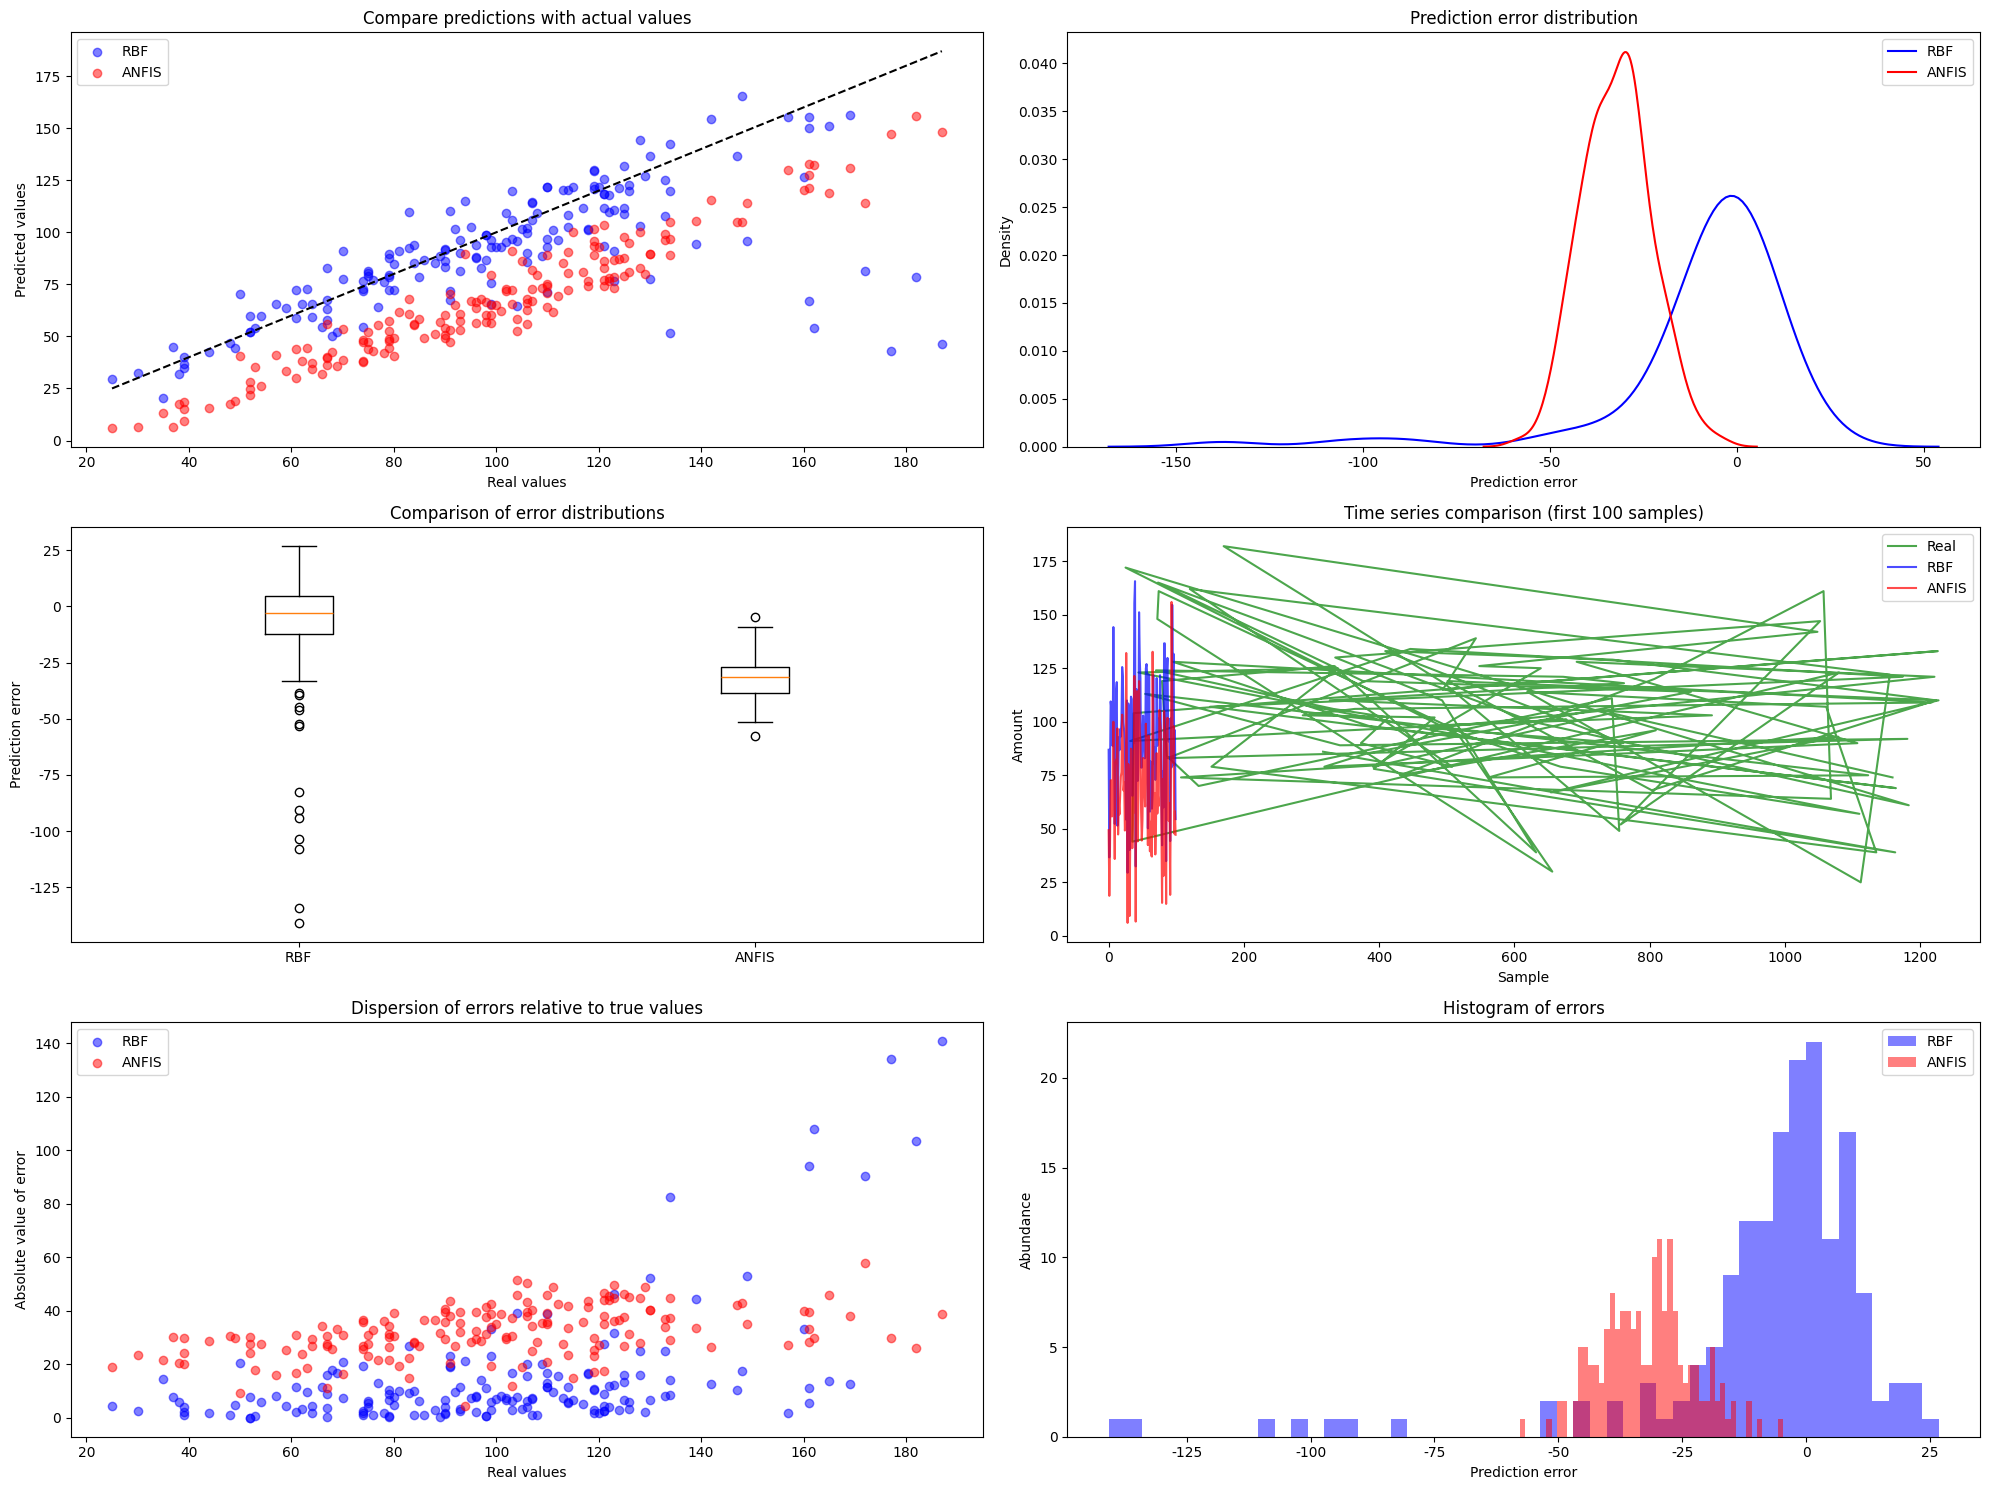

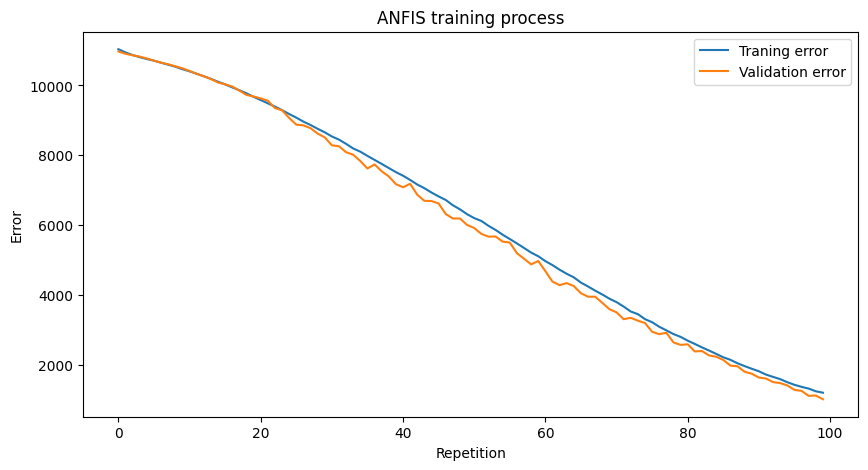


آمار توصیفی خطاها:

RBF Error Statistics:
count    166.000000
mean      -8.441365
std       25.205473
min     -140.740574
25%      -12.366946
50%       -2.766030
75%        4.473012
max       26.722437
Name: NO2(GT), dtype: float64

ANFIS Error Statistics:
count    166.000000
mean     -32.107592
std        9.228689
min      -57.720253
25%      -38.744493
50%      -31.276583
75%      -26.812955
max       -4.620087
Name: NO2(GT), dtype: float64

درصد خطاهای بزرگ (بیشتر از یک انحراف معیار):
RBF: 9.04%
ANFIS: 46.39%


In [ ]:
def main():
    try:
        # مسیر فایل داده
        file_path = 'AirQualityUCI.xlsx'

        # بارگذاری و پیش‌پردازش داده‌ها
        X, y = load_and_preprocess_data(file_path)

        # آموزش مدل‌ها
        rbf_predictions, anfis_predictions, y_test, history, X_test_scaled = create_and_train_models(X, y)

        # ارزیابی و نمایش نتایج
        enhanced_evaluate_and_visualize(rbf_predictions, anfis_predictions, y_test, history, X_test_scaled)

    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()